In [1]:
import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage, spatial
from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from skimage import io, transform,data
from torchvision import transforms, utils
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
import cv2
from matplotlib import pyplot as plt
import numpy as np
from os.path import exists
import pandas as pd
import PIL
import random
from google.colab import drive
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import KMeans
from tqdm import tqdm, tqdm_notebook
from functools import partial
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
import h5py as h5

#cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#print("Accelerator type = ",accelerator)
#print("Pytorch verision: ", torch.__version__)

In [2]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#!pip install ipython-autotime

#%load_ext autotime

In [4]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

In [5]:
class Image:
    def __init__(self, img, position):
        
        self.img = img
        self.position = position

inlier_matchset = []
def features_matching(a,keypointlength,threshold):
  #threshold=0.2
  bestmatch=np.empty((keypointlength),dtype= np.int16)
  img1index=np.empty((keypointlength),dtype=np.int16)
  distance=np.empty((keypointlength))
  index=0
  for j in range(0,keypointlength):
    #For a descriptor fa in Ia, take the two closest descriptors fb1 and fb2 in Ib
    x=a[j]
    listx=x.tolist()
    x.sort()
    minval1=x[0]                                # min 
    minval2=x[1]                                # 2nd min
    itemindex1 = listx.index(minval1)           #index of min val    
    itemindex2 = listx.index(minval2)           #index of second min value 
    ratio=minval1/minval2                       #Ratio Test
    
    if ratio<threshold: 
      #Low distance ratio: fb1 can be a good match
      bestmatch[index]=itemindex1
      distance[index]=minval1
      img1index[index]=j
      index=index+1
  return  [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
          
   
  
def compute_Homography(im1_pts,im2_pts):
  """
  im1_pts and im2_pts are 2×n matrices with
  4 point correspondences from the two images
  """
  num_matches=len(im1_pts)
  num_rows = 2 * num_matches
  num_cols = 9
  A_matrix_shape = (num_rows,num_cols)
  A = np.zeros(A_matrix_shape)
  a_index = 0
  for i in range(0,num_matches):
    (a_x, a_y) = im1_pts[i]
    (b_x, b_y) = im2_pts[i]
    row1 = [a_x, a_y, 1, 0, 0, 0, -b_x*a_x, -b_x*a_y, -b_x] # First row 
    row2 = [0, 0, 0, a_x, a_y, 1, -b_y*a_x, -b_y*a_y, -b_y] # Second row 

    # place the rows in the matrix
    A[a_index] = row1
    A[a_index+1] = row2

    a_index += 2
    
  U, s, Vt = np.linalg.svd(A)

  #s is a 1-D array of singular values sorted in descending order
  #U, Vt are unitary matrices
  #Rows of Vt are the eigenvectors of A^TA.
  #Columns of U are the eigenvectors of AA^T.
  H = np.eye(3)
  H = Vt[-1].reshape(3,3) # take the last row of the Vt matrix
  return H
  
  
def displayplot(img,title):
  
  plt.figure(figsize=(15,15))
  plt.title(title)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

In [6]:
def get_inliers(f1, f2, matches, H, RANSACthresh):

  inlier_indices = []
  for i in range(len(matches)):
    queryInd = matches[i].queryIdx
    trainInd = matches[i].trainIdx

    #queryInd = matches[i][0]
    #trainInd = matches[i][1]

    queryPoint = np.array([f1[queryInd].pt[0],  f1[queryInd].pt[1], 1]).T 
    trans_query = H.dot(queryPoint) 

   
    comp1 = [trans_query[0]/trans_query[2], trans_query[1]/trans_query[2]] # normalize with respect to z
    comp2 = np.array(f2[trainInd].pt)[:2]
    

    if(np.linalg.norm(comp1-comp2) <= RANSACthresh): # check against threshold
      inlier_indices.append(i)
  return inlier_indices


def RANSAC_alg(f1, f2, matches, nRANSAC, RANSACthresh):

      
    minMatches = 4
    nBest = 0
    best_inliers = []
    H_estimate = np.eye(3,3)
    global inlier_matchset
    inlier_matchset=[]
    for iteration in range(nRANSAC):
      
        #Choose a minimal set of feature matches.
        matchSample = random.sample(matches, minMatches)
        
        #Estimate the Homography implied by these matches
        im1_pts=np.empty((minMatches,2))
        im2_pts=np.empty((minMatches,2))
        for i in range(0,minMatches):
          m = matchSample[i]
          im1_pts[i] = f1[m.queryIdx].pt
          im2_pts[i] = f2[m.trainIdx].pt
          #im1_pts[i] = f1[m[0]].pt
          #im2_pts[i] = f2[m[1]].pt             
          
        H_estimate=compute_Homography(im1_pts,im2_pts)
        
               
        # Calculate the inliers for the H
        inliers = get_inliers(f1, f2, matches, H_estimate, RANSACthresh)

        # if the number of inliers is higher than previous iterations, update the best estimates
        if len(inliers) > nBest:
            nBest= len(inliers)
            best_inliers = inliers

    print("Number of best inliers",len(best_inliers))
    for i in range(len(best_inliers)):
      inlier_matchset.append(matches[best_inliers[i]])
    
    # compute a homography given this set of matches
    im1_pts=np.empty((len(best_inliers),2))
    im2_pts=np.empty((len(best_inliers),2))
    for i in range(0,len(best_inliers)):
      m = inlier_matchset[i]
      im1_pts[i] = f1[m.queryIdx].pt
      im2_pts[i] = f2[m.trainIdx].pt
      #im1_pts[i] = f1[m[0]].pt
      #im2_pts[i] = f2[m[1]].pt

    M=compute_Homography(im1_pts,im2_pts)
    return M, best_inliers

In [7]:
tqdm = partial(tqdm, position=0, leave=True)

In [8]:
files_all=[]
for file in os.listdir("/content/drive/MyDrive/geotagged-images"):
    if file.endswith(".JPG"):
      files_all.append(file)


files_all.sort()
folder_path = '/content/drive/MyDrive/geotagged-images/'

#centre_file = folder_path + files_all[50]
left_files_path_rev = []
right_files_path = []


#Change this according to your dataset split

for file in files_all[:61]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[60:120]:
  right_files_path.append(folder_path + file)

In [9]:
print(len(files_all))

297


In [10]:
from multiprocessing import Pool

In [11]:
import multiprocessing
print(multiprocessing.cpu_count())


2


In [12]:
gridsize = 8
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))

images_left_bgr = []
images_right_bgr = []

images_left = []
images_right = []

for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(left_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  left_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC )
  images_left.append(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_left_bgr.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(right_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  right_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC )
  images_right.append(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_right_bgr.append(right_img)

100%|██████████| 60/60 [01:36<00:00,  1.61s/it]


In [13]:
Dataset = 'Small Village Dataset'

In [14]:
f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left_bgr + images_right_bgr)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_bgr_{Dataset}.h5')/1.e6,'MB')

HDF5  w/o comp.: 2.845696210861206 [s] ... size 708.480038 MB


In [15]:
f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left + images_right)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_gray_{Dataset}.h5')/1.e6,'MB')

HDF5  w/o comp.: 4.992582559585571 [s] ... size 944.639368 MB


In [16]:
del images_left_bgr,images_right_bgr

In [17]:
from timeit import default_timer as timer

In [18]:
time_all = []

In [19]:
num_kps_sift = []
num_kps_brisk = []
num_kps_agast = []
num_kps_kaze = []
num_kps_akaze = []
num_kps_orb = []
num_kps_mser = []
num_kps_daisy = []
num_kps_surfsift = []
num_kps_fast = []
num_kps_freak = []
num_kps_gftt = []
num_kps_star = []
num_kps_surf = []
num_kps_rootsift = []
num_kps_superpoint = []


BRISK

In [79]:
Threshl=60;
Octaves=6; 
#PatternScales=1.0f;

start = timer()

brisk = cv2.BRISK_create(Threshl,Octaves)


keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk=[]

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_left_brisk.append(kpt)
  descriptors_all_left_brisk.append(descrip)
  #points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_right_brisk.append(kpt)
  descriptors_all_right_brisk.append(descrip)
  #points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:36<00:00,  1.67it/s]


In [80]:
for j in tqdm(keypoints_all_left_brisk + keypoints_all_right_brisk[1:]):
  num_kps_brisk.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 294337.12it/s]


In [81]:
all_feat_brisk_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_brisk):
  all_feat_brisk_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_left_each.append(temp)
  all_feat_brisk_left.append(all_feat_brisk_left_each)

In [82]:
all_feat_brisk_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_brisk):
  all_feat_brisk_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_right_each.append(temp)
  all_feat_brisk_right.append(all_feat_brisk_right_each)

In [83]:
del keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk

In [84]:
import pickle
Fdb = open('all_feat_brisk_left.dat', 'wb')
pickle.dump(all_feat_brisk_left,Fdb,-1)
Fdb.close()

In [85]:
import pickle
Fdb = open('all_feat_brisk_right.dat', 'wb')
pickle.dump(all_feat_brisk_right,Fdb,-1)
Fdb.close()

In [86]:
del Fdb, all_feat_brisk_left, all_feat_brisk_right

MSER + SIFT

In [20]:
start = timer()

mser = cv2.MSER_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_mser = []
descriptors_all_left_mser = []
points_all_left_mser=[]

keypoints_all_right_mser = []
descriptors_all_right_mser = []
points_all_right_mser=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_mser.append(kpt)
  descriptors_all_left_mser.append(descrip)
  #points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_mser.append(kpt)
  descriptors_all_right_mser.append(descrip)
  #points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [04:32<00:00,  4.54s/it]


In [21]:
for j in tqdm(keypoints_all_left_mser + keypoints_all_right_mser[1:]):
  num_kps_mser.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 59790.51it/s]


In [22]:
all_feat_mser_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_mser):
  all_feat_mser_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_left_each.append(temp)
  all_feat_mser_left.append(all_feat_mser_left_each)

In [23]:
all_feat_mser_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_mser):
  all_feat_mser_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_right_each.append(temp)
  all_feat_mser_right.append(all_feat_mser_right_each)

In [24]:
del keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser

In [25]:
import pickle
Fdb = open('all_feat_mser_left.dat', 'wb')
pickle.dump(all_feat_mser_left,Fdb,-1)
Fdb.close()

In [26]:
import pickle
Fdb = open('all_feat_mser_right.dat', 'wb')
pickle.dump(all_feat_mser_right,Fdb,-1)
Fdb.close()

In [27]:
del Fdb, all_feat_mser_left, all_feat_mser_right

FAST + SIFT

In [28]:
start = timer()


fast = cv2.FastFeatureDetector_create(threshold=40)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_fast = []
descriptors_all_left_fast = []
points_all_left_fast=[]

keypoints_all_right_fast = []
descriptors_all_right_fast = []
points_all_right_fast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_fast.append(kpt)
  descriptors_all_left_fast.append(descrip)
  #points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_fast.append(kpt)
  descriptors_all_right_fast.append(descrip)
  #points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [02:35<00:00,  2.59s/it]


In [29]:
for j in tqdm(keypoints_all_left_fast + keypoints_all_right_fast[1:]):
  num_kps_fast.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 128495.40it/s]


In [30]:
all_feat_fast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_fast):
  all_feat_fast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_left_each.append(temp)
  all_feat_fast_left.append(all_feat_fast_left_each)

In [31]:
all_feat_fast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_fast):
  all_feat_fast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_right_each.append(temp)
  all_feat_fast_right.append(all_feat_fast_right_each)

In [32]:
del keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast

In [33]:
import pickle
Fdb = open('all_feat_fast_left.dat', 'wb')
pickle.dump(all_feat_fast_left,Fdb,-1)
Fdb.close()

In [34]:
import pickle
Fdb = open('all_feat_fast_right.dat', 'wb')
pickle.dump(all_feat_fast_right,Fdb,-1)
Fdb.close()

In [35]:
del Fdb, all_feat_fast_left, all_feat_fast_right

GFTT + SIFT

In [36]:
start = timer()

gftt = cv2.GFTTDetector_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []
points_all_left_gftt=[]

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []
points_all_right_gftt=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_gftt.append(kpt)
  descriptors_all_left_gftt.append(descrip)
  #points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_gftt.append(kpt)
  descriptors_all_right_gftt.append(descrip)
  #points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:11<00:00,  5.12it/s]


In [37]:
for j in tqdm(keypoints_all_left_gftt + keypoints_all_right_gftt[1:]):
  num_kps_gftt.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 89494.40it/s]


In [38]:
all_feat_gftt_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_gftt):
  all_feat_gftt_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_left_each.append(temp)
  all_feat_gftt_left.append(all_feat_gftt_left_each)

In [39]:
all_feat_gftt_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_gftt):
  all_feat_gftt_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_right_each.append(temp)
  all_feat_gftt_right.append(all_feat_gftt_right_each)

In [40]:
del keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt

In [41]:
import pickle
Fdb = open('all_feat_gftt_left.dat', 'wb')
pickle.dump(all_feat_gftt_left,Fdb,-1)
Fdb.close()

In [42]:
import pickle
Fdb = open('all_feat_gftt_right.dat', 'wb')
pickle.dump(all_feat_gftt_right,Fdb,-1)
Fdb.close()

In [43]:
del Fdb, all_feat_gftt_left, all_feat_gftt_right

DAISY+SIFT

In [44]:
start = timer()

daisy = cv2.xfeatures2d.DAISY_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []
points_all_left_daisy=[]

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []
points_all_right_daisy=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_left_daisy.append(kpt)
  descriptors_all_left_daisy.append(descrip)
  #points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_right_daisy.append(kpt)
  descriptors_all_right_daisy.append(descrip)
  #points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:02<00:00,  1.04s/it]


In [45]:
for j in tqdm(keypoints_all_left_daisy + keypoints_all_right_daisy[1:]):
  num_kps_daisy.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 427990.20it/s]


In [46]:
all_feat_daisy_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_daisy):
  all_feat_daisy_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_left_each.append(temp)
  all_feat_daisy_left.append(all_feat_daisy_left_each)

In [47]:
all_feat_daisy_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_daisy):
  all_feat_daisy_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_right_each.append(temp)
  all_feat_daisy_right.append(all_feat_daisy_right_each)

In [48]:
del keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy

In [49]:
import pickle
Fdb = open('all_feat_daisy_left.dat', 'wb')
pickle.dump(all_feat_daisy_left,Fdb,-1)
Fdb.close()

In [50]:
import pickle
Fdb = open('all_feat_daisy_right.dat', 'wb')
pickle.dump(all_feat_daisy_right,Fdb,-1)
Fdb.close()

In [51]:
del Fdb, all_feat_daisy_left, all_feat_daisy_right

SIFT

In [52]:
print(len(left_files_path))

61


In [53]:
print(len(right_files_path))

60


In [54]:
# H5 file w/o compression
#t0=time.time()
#f=h5.File('drive/MyDrive/all_images_bgr_sift.h5','r')
#print('HDF5  w/o comp.: data shape =',len(f['data'][0]),time.time()-t0,'[s]')
#f.close()

In [55]:
# del f

In [56]:
start = timer()

sift = cv2.xfeatures2d.SIFT_create()
keypoints_all_left_sift = []
descriptors_all_left_sift = []
points_all_left_sift=[]

keypoints_all_right_sift = []
descriptors_all_right_sift = []
points_all_right_sift=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_sift.append(kpt)
  descriptors_all_left_sift.append(descrip)
  #points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_sift.append(kpt)
  descriptors_all_right_sift.append(descrip)
  #points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:34<00:00,  1.57s/it]


In [57]:
for j in tqdm(keypoints_all_left_sift + keypoints_all_right_sift[1:]):
  num_kps_sift.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 337569.74it/s]


In [58]:
all_feat_sift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_sift):
  all_feat_sift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_left_each.append(temp)
  all_feat_sift_left.append(all_feat_sift_left_each)

In [59]:
all_feat_sift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_sift):
  all_feat_sift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_right_each.append(temp)
  all_feat_sift_right.append(all_feat_sift_right_each)

In [60]:
del keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift

In [61]:
import pickle
Fdb = open('all_feat_sift_left.dat', 'wb')
pickle.dump(all_feat_sift_left,Fdb,-1)
Fdb.close()

In [62]:
import pickle
Fdb = open('all_feat_sift_right.dat', 'wb')
pickle.dump(all_feat_sift_right,Fdb,-1)
Fdb.close()

In [63]:
del Fdb, all_feat_sift_left, all_feat_sift_right

In [ ]:
#del keypoints_all_right_sift, keypoints_all_left_sift, descriptors_all_right_sift, descriptors_all_left_sift, points_all_right_sift, points_all_left_sift

SURF

In [64]:
start = timer()

surf  = cv2.xfeatures2d.SURF_create(upright=1)
keypoints_all_left_surf = []
descriptors_all_left_surf = []
points_all_left_surf=[]

keypoints_all_right_surf = []
descriptors_all_right_surf = []
points_all_right_surf=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_left_surf.append(kpt)
  descriptors_all_left_surf.append(descrip)
  #points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_right_surf.append(kpt)
  descriptors_all_right_surf.append(descrip)
  #points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:40<00:00,  1.68s/it]


In [65]:
for j in tqdm(keypoints_all_left_surf + keypoints_all_right_surf[1:]):
  num_kps_surf.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 301387.11it/s]


In [66]:
all_feat_surf_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surf):
  all_feat_surf_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_left_each.append(temp)
  all_feat_surf_left.append(all_feat_surf_left_each)

In [67]:
all_feat_surf_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surf):
  all_feat_surf_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_right_each.append(temp)
  all_feat_surf_right.append(all_feat_surf_right_each)

In [68]:
del keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf

In [69]:
import pickle
Fdb = open('all_feat_surf_left.dat', 'wb')
pickle.dump(all_feat_surf_left,Fdb,-1)
Fdb.close()

In [70]:
import pickle
Fdb = open('all_feat_surf_right.dat', 'wb')
pickle.dump(all_feat_surf_right,Fdb,-1)
Fdb.close()

In [71]:
del Fdb, all_feat_surf_left, all_feat_surf_right

Total Matches,Robust Matches and Homography Computation

In [72]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC, ransacReprojThreshold =thresh, maxIters=3000)
    inliers = inliers.flatten()
    return H, inliers

In [73]:
def compute_homography_fast_other(matched_pts1, matched_pts2):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    0)
    inliers = inliers.flatten()
    return H, inliers

In [74]:
def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.75,thresh=4,use_lowe=True,disp=False,no_ransac=False,binary=False):
  lff1 = descripts[0]
  lff = descripts[1]

  if use_lowe==False:
    #FLANN_INDEX_KDTREE = 2
    #index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    #search_params = dict(checks=50)
    #flann = cv2.FlannBasedMatcher(index_params, search_params)
    #flann = cv2.BFMatcher()
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    #matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    matches_4 = bf.knnMatch(lff1, lff,k=2)
    matches_lf1_lf = []


    print("\nNumber of matches",len(matches_4))
    '''
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      #if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
      matches_4.append(m[0])
    '''
    print("Number of matches After Lowe's Ratio",len(matches_4))
  else:
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])
    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    #matches_lf1_lf = bf.knnMatch(lff1, lff,k=2)


    print("\nNumber of matches",len(matches_lf1_lf))
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])
  
    print("Number of matches After Lowe's Ratio",len(matches_4))


  
  matches_idx = np.array([m.queryIdx for m in matches_4])
  imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
  matches_idx = np.array([m.trainIdx for m in matches_4])
  imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
  '''
  # Estimate homography 1
  #Compute H1
  # Estimate homography 1
  #Compute H1
  imm1_pts=np.empty((len(matches_4),2))
  imm2_pts=np.empty((len(matches_4),2))
  for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1000, RANSACthresh=6)
  '''
  
  if no_ransac==True:
    Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)
  else:
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts,thresh)  

  inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
  print("Number of Robust matches",len(inlier_matchset))
  print("\n")
  
  if len(inlier_matchset)<25:
    matches_4 = []
    ratio = 0.85
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
          matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio New",len(matches_4))
  
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matches_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts)  
    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches New",len(inlier_matchset))
    print("\n")    
  
  #H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1500, RANSACthresh=6)

  #global inlier_matchset   
  
  if disp==True:
    dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
  
  
  return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

In [75]:
def get_Hmatrix_rfnet(imgs,pts,descripts,disp=True):

  des1 = descripts[0]
  des2 = descripts[1]

  kp1 = pts[0]
  kp2 = pts[1]


  predict_label, nn_kp2 = nearest_neighbor_distance_ratio_match(des1, des2, kp2, 0.7)
  idx = predict_label.nonzero().view(-1)
  mkp1 = kp1.index_select(dim=0, index=idx.long())  # predict match keypoints in I1
  mkp2 = nn_kp2.index_select(dim=0, index=idx.long())  # predict match keypoints in I2

  #img1, img2 = reverse_img(img1), reverse_img(img2)
  keypoints1 = list(map(to_cv2_kp, mkp1))
  keypoints2 = list(map(to_cv2_kp, mkp2))
  DMatch = list(map(to_cv2_dmatch, np.arange(0, len(keypoints1))))

  imm1_pts=np.empty((len(DMatch),2))
  imm2_pts=np.empty((len(DMatch),2))
  for i in range(0,len(DMatch)):
    m = DMatch[i]
    (a_x, a_y) = keypoints1[m.queryIdx].pt
    (b_x, b_y) = keypoints2[m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography_fast(imm1_pts,imm2_pts) 


  if disp==True:
    dispimg1 = cv2.drawMatches(imgs[0], keypoints1, imgs[1], keypoints2, DMatch, None)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')


  return H/H[2,2]

In [87]:
import pickle
Fdb = open('all_feat_brisk_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_brisk.append(keypoints_each)
  descriptors_all_left_brisk.append(descrip_each)

In [88]:
import pickle
Fdb = open('all_feat_brisk_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_brisk.append(keypoints_each)
  descriptors_all_right_brisk.append(descrip_each)

In [89]:
H_left_brisk = []
H_right_brisk = []

num_matches_brisk = []
num_good_matches_brisk = []

images_left_bgr = []
images_right_bgr = []
for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_brisk[j:j+2][::-1],points_all_left_brisk[j:j+2][::-1],descriptors_all_left_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_left_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_brisk[j:j+2][::-1],points_all_right_brisk[j:j+2][::-1],descriptors_all_right_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_right_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

  2%|▏         | 1/61 [00:01<01:51,  1.86s/it]


Number of matches 23362
Number of matches After Lowe's Ratio 328
Number of Robust matches 150




  3%|▎         | 2/61 [00:04<02:03,  2.09s/it]


Number of matches 23772
Number of matches After Lowe's Ratio 424
Number of Robust matches 227




  5%|▍         | 3/61 [00:06<02:02,  2.10s/it]


Number of matches 20529
Number of matches After Lowe's Ratio 373
Number of Robust matches 164




  7%|▋         | 4/61 [00:08<01:55,  2.03s/it]


Number of matches 20226
Number of matches After Lowe's Ratio 454
Number of Robust matches 284




  8%|▊         | 5/61 [00:10<01:49,  1.96s/it]


Number of matches 20276
Number of matches After Lowe's Ratio 275
Number of Robust matches 179




 10%|▉         | 6/61 [00:12<01:46,  1.94s/it]


Number of matches 22532
Number of matches After Lowe's Ratio 656
Number of Robust matches 524




 11%|█▏        | 7/61 [00:14<01:52,  2.09s/it]


Number of matches 21759
Number of matches After Lowe's Ratio 645
Number of Robust matches 514




 13%|█▎        | 8/61 [00:16<01:48,  2.05s/it]


Number of matches 19261
Number of matches After Lowe's Ratio 463
Number of Robust matches 344




 15%|█▍        | 9/61 [00:18<01:42,  1.97s/it]


Number of matches 21274
Number of matches After Lowe's Ratio 492
Number of Robust matches 326




 16%|█▋        | 10/61 [00:20<01:40,  1.98s/it]


Number of matches 22411
Number of matches After Lowe's Ratio 482
Number of Robust matches 279




 18%|█▊        | 11/61 [00:22<01:45,  2.11s/it]


Number of matches 21614
Number of matches After Lowe's Ratio 397
Number of Robust matches 147




 20%|█▉        | 12/61 [00:24<01:41,  2.08s/it]


Number of matches 21161
Number of matches After Lowe's Ratio 359
Number of Robust matches 113




 21%|██▏       | 13/61 [00:27<01:41,  2.12s/it]


Number of matches 29227
Number of matches After Lowe's Ratio 104
Number of Robust matches 37




 23%|██▎       | 14/61 [00:30<02:04,  2.65s/it]


Number of matches 42924
Number of matches After Lowe's Ratio 68
Number of Robust matches 39




 25%|██▍       | 15/61 [00:35<02:28,  3.24s/it]


Number of matches 24645
Number of matches After Lowe's Ratio 155
Number of Robust matches 81




 26%|██▌       | 16/61 [00:37<02:11,  2.93s/it]


Number of matches 19933
Number of matches After Lowe's Ratio 329
Number of Robust matches 133




 28%|██▊       | 17/61 [00:39<01:54,  2.60s/it]


Number of matches 21057
Number of matches After Lowe's Ratio 313
Number of Robust matches 138




 30%|██▉       | 18/61 [00:41<01:44,  2.43s/it]


Number of matches 24507
Number of matches After Lowe's Ratio 251
Number of Robust matches 88




 31%|███       | 19/61 [00:44<01:45,  2.51s/it]


Number of matches 21769
Number of matches After Lowe's Ratio 234
Number of Robust matches 104




 33%|███▎      | 20/61 [00:46<01:37,  2.38s/it]


Number of matches 22982
Number of matches After Lowe's Ratio 213
Number of Robust matches 93




 34%|███▍      | 21/61 [00:48<01:33,  2.33s/it]


Number of matches 23768
Number of matches After Lowe's Ratio 373
Number of Robust matches 252




 36%|███▌      | 22/61 [00:51<01:39,  2.55s/it]


Number of matches 28262
Number of matches After Lowe's Ratio 497
Number of Robust matches 361




 38%|███▊      | 23/61 [00:54<01:38,  2.58s/it]


Number of matches 21439
Number of matches After Lowe's Ratio 397
Number of Robust matches 318




 39%|███▉      | 24/61 [00:56<01:28,  2.39s/it]


Number of matches 18334
Number of matches After Lowe's Ratio 174
Number of Robust matches 86




 41%|████      | 25/61 [00:57<01:17,  2.16s/it]


Number of matches 18808
Number of matches After Lowe's Ratio 182
Number of Robust matches 88




 43%|████▎     | 26/61 [00:59<01:12,  2.06s/it]


Number of matches 22324
Number of matches After Lowe's Ratio 130
Number of Robust matches 44




 44%|████▍     | 27/61 [01:02<01:14,  2.18s/it]


Number of matches 21698
Number of matches After Lowe's Ratio 326
Number of Robust matches 103




 46%|████▌     | 28/61 [01:04<01:10,  2.15s/it]


Number of matches 23810
Number of matches After Lowe's Ratio 136
Number of Robust matches 49




 48%|████▊     | 29/61 [01:06<01:13,  2.31s/it]


Number of matches 36286
Number of matches After Lowe's Ratio 88
Number of Robust matches 35




 49%|████▉     | 30/61 [01:11<01:28,  2.87s/it]


Number of matches 27657
Number of matches After Lowe's Ratio 107
Number of Robust matches 52




 51%|█████     | 31/61 [01:13<01:25,  2.84s/it]


Number of matches 21101
Number of matches After Lowe's Ratio 175
Number of Robust matches 56




 52%|█████▏    | 32/61 [01:15<01:13,  2.54s/it]


Number of matches 16364
Number of matches After Lowe's Ratio 272
Number of Robust matches 94




 54%|█████▍    | 33/61 [01:16<01:00,  2.16s/it]


Number of matches 17594
Number of matches After Lowe's Ratio 296
Number of Robust matches 122




 56%|█████▌    | 34/61 [01:18<00:53,  1.97s/it]


Number of matches 17284
Number of matches After Lowe's Ratio 238
Number of Robust matches 91




 57%|█████▋    | 35/61 [01:20<00:51,  1.97s/it]


Number of matches 18551
Number of matches After Lowe's Ratio 207
Number of Robust matches 97




 59%|█████▉    | 36/61 [01:22<00:47,  1.90s/it]


Number of matches 22945
Number of matches After Lowe's Ratio 300
Number of Robust matches 215




 61%|██████    | 37/61 [01:24<00:50,  2.10s/it]


Number of matches 27055
Number of matches After Lowe's Ratio 325
Number of Robust matches 209




 62%|██████▏   | 38/61 [01:27<00:50,  2.19s/it]


Number of matches 18460
Number of matches After Lowe's Ratio 388
Number of Robust matches 261




 64%|██████▍   | 39/61 [01:28<00:44,  2.01s/it]


Number of matches 14294
Number of matches After Lowe's Ratio 255
Number of Robust matches 152




 66%|██████▌   | 40/61 [01:29<00:35,  1.70s/it]


Number of matches 9266
Number of matches After Lowe's Ratio 157
Number of Robust matches 96




 67%|██████▋   | 41/61 [01:30<00:30,  1.50s/it]


Number of matches 12189
Number of matches After Lowe's Ratio 173
Number of Robust matches 76




 69%|██████▉   | 42/61 [01:31<00:25,  1.33s/it]


Number of matches 15822
Number of matches After Lowe's Ratio 254
Number of Robust matches 104




 70%|███████   | 43/61 [01:33<00:23,  1.33s/it]


Number of matches 22856
Number of matches After Lowe's Ratio 175
Number of Robust matches 60




 72%|███████▏  | 44/61 [01:35<00:28,  1.69s/it]


Number of matches 33250
Number of matches After Lowe's Ratio 64
Number of Robust matches 29




 74%|███████▍  | 45/61 [01:40<00:41,  2.59s/it]


Number of matches 48322
Number of matches After Lowe's Ratio 73
Number of Robust matches 49




 75%|███████▌  | 46/61 [01:45<00:53,  3.54s/it]


Number of matches 31149
Number of matches After Lowe's Ratio 67
Number of Robust matches 40




 77%|███████▋  | 47/61 [01:48<00:47,  3.37s/it]


Number of matches 19883
Number of matches After Lowe's Ratio 77
Number of Robust matches 55




 79%|███████▊  | 48/61 [01:51<00:38,  3.00s/it]


Number of matches 16022
Number of matches After Lowe's Ratio 104
Number of Robust matches 35




 80%|████████  | 49/61 [01:52<00:29,  2.44s/it]


Number of matches 9922
Number of matches After Lowe's Ratio 189
Number of Robust matches 67




 82%|████████▏ | 50/61 [01:52<00:21,  1.93s/it]


Number of matches 12508
Number of matches After Lowe's Ratio 146
Number of Robust matches 66




 84%|████████▎ | 51/61 [01:53<00:16,  1.63s/it]


Number of matches 16045
Number of matches After Lowe's Ratio 138
Number of Robust matches 112




 85%|████████▌ | 52/61 [01:55<00:13,  1.53s/it]


Number of matches 22498
Number of matches After Lowe's Ratio 251
Number of Robust matches 190




 87%|████████▋ | 53/61 [01:57<00:15,  1.90s/it]


Number of matches 27537
Number of matches After Lowe's Ratio 281
Number of Robust matches 205




 89%|████████▊ | 54/61 [02:00<00:15,  2.15s/it]


Number of matches 26008
Number of matches After Lowe's Ratio 336
Number of Robust matches 282




 90%|█████████ | 55/61 [02:03<00:13,  2.20s/it]


Number of matches 18498
Number of matches After Lowe's Ratio 139
Number of Robust matches 92




 92%|█████████▏| 56/61 [02:04<00:10,  2.01s/it]


Number of matches 14864
Number of matches After Lowe's Ratio 76
Number of Robust matches 59




 93%|█████████▎| 57/61 [02:05<00:06,  1.73s/it]


Number of matches 13916
Number of matches After Lowe's Ratio 91
Number of Robust matches 49




 95%|█████████▌| 58/61 [02:06<00:04,  1.51s/it]


Number of matches 12079
Number of matches After Lowe's Ratio 138
Number of Robust matches 58




 97%|█████████▋| 59/61 [02:08<00:02,  1.47s/it]


Number of matches 22714
Number of matches After Lowe's Ratio 93
Number of Robust matches 38




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 33432
Number of matches After Lowe's Ratio 58
Number of Robust matches 38




  2%|▏         | 1/60 [00:01<01:56,  1.98s/it]


Number of matches 23671
Number of matches After Lowe's Ratio 203
Number of Robust matches 72




  3%|▎         | 2/60 [00:04<02:11,  2.27s/it]


Number of matches 31126
Number of matches After Lowe's Ratio 134
Number of Robust matches 50




  5%|▌         | 3/60 [00:07<02:21,  2.49s/it]


Number of matches 22478
Number of matches After Lowe's Ratio 76
Number of Robust matches 30




  7%|▋         | 4/60 [00:10<02:12,  2.37s/it]


Number of matches 21734
Number of matches After Lowe's Ratio 146
Number of Robust matches 63




  8%|▊         | 5/60 [00:12<02:05,  2.29s/it]


Number of matches 22994
Number of matches After Lowe's Ratio 378
Number of Robust matches 170




 10%|█         | 6/60 [00:14<02:08,  2.38s/it]


Number of matches 23656
Number of matches After Lowe's Ratio 330
Number of Robust matches 167




 12%|█▏        | 7/60 [00:17<02:04,  2.35s/it]


Number of matches 21254
Number of matches After Lowe's Ratio 494
Number of Robust matches 266




 13%|█▎        | 8/60 [00:18<01:55,  2.22s/it]


Number of matches 18348
Number of matches After Lowe's Ratio 531
Number of Robust matches 336




 15%|█▌        | 9/60 [00:20<01:43,  2.03s/it]


Number of matches 15386
Number of matches After Lowe's Ratio 558
Number of Robust matches 346




 17%|█▋        | 10/60 [00:21<01:28,  1.77s/it]


Number of matches 14197
Number of matches After Lowe's Ratio 700
Number of Robust matches 588




 18%|█▊        | 11/60 [00:22<01:16,  1.55s/it]


Number of matches 14838
Number of matches After Lowe's Ratio 511
Number of Robust matches 412




 20%|██        | 12/60 [00:24<01:14,  1.55s/it]


Number of matches 20411
Number of matches After Lowe's Ratio 497
Number of Robust matches 358




 22%|██▏       | 13/60 [00:26<01:18,  1.67s/it]


Number of matches 22391
Number of matches After Lowe's Ratio 595
Number of Robust matches 312




 23%|██▎       | 14/60 [00:28<01:25,  1.85s/it]


Number of matches 23990
Number of matches After Lowe's Ratio 554
Number of Robust matches 291




 25%|██▌       | 15/60 [00:30<01:30,  2.01s/it]


Number of matches 23318
Number of matches After Lowe's Ratio 339
Number of Robust matches 183




 27%|██▋       | 16/60 [00:33<01:35,  2.18s/it]


Number of matches 18324
Number of matches After Lowe's Ratio 366
Number of Robust matches 180




 28%|██▊       | 17/60 [00:35<01:26,  2.01s/it]


Number of matches 18227
Number of matches After Lowe's Ratio 201
Number of Robust matches 109




 30%|███       | 18/60 [00:36<01:20,  1.92s/it]


Number of matches 21859
Number of matches After Lowe's Ratio 183
Number of Robust matches 79




 32%|███▏      | 19/60 [00:38<01:18,  1.91s/it]


Number of matches 17217
Number of matches After Lowe's Ratio 72
Number of Robust matches 35




 33%|███▎      | 20/60 [00:40<01:11,  1.79s/it]


Number of matches 17475
Number of matches After Lowe's Ratio 187
Number of Robust matches 93




 35%|███▌      | 21/60 [00:42<01:13,  1.89s/it]


Number of matches 25638
Number of matches After Lowe's Ratio 354
Number of Robust matches 188




 37%|███▋      | 22/60 [00:44<01:19,  2.09s/it]


Number of matches 23870
Number of matches After Lowe's Ratio 398
Number of Robust matches 188




 38%|███▊      | 23/60 [00:47<01:19,  2.14s/it]


Number of matches 20525
Number of matches After Lowe's Ratio 466
Number of Robust matches 254




 40%|████      | 24/60 [00:48<01:13,  2.06s/it]


Number of matches 18552
Number of matches After Lowe's Ratio 623
Number of Robust matches 341




 42%|████▏     | 25/60 [00:50<01:06,  1.90s/it]


Number of matches 13365
Number of matches After Lowe's Ratio 870
Number of Robust matches 644




 43%|████▎     | 26/60 [00:51<00:57,  1.69s/it]


Number of matches 6035
Number of matches After Lowe's Ratio 444
Number of Robust matches 403




 45%|████▌     | 27/60 [00:52<00:43,  1.33s/it]


Number of matches 10355
Number of matches After Lowe's Ratio 297
Number of Robust matches 270




 47%|████▋     | 28/60 [00:53<00:38,  1.20s/it]


Number of matches 21694
Number of matches After Lowe's Ratio 637
Number of Robust matches 541




 48%|████▊     | 29/60 [00:55<00:46,  1.49s/it]


Number of matches 26495
Number of matches After Lowe's Ratio 791
Number of Robust matches 506




 50%|█████     | 30/60 [00:57<00:55,  1.84s/it]


Number of matches 25861
Number of matches After Lowe's Ratio 542
Number of Robust matches 226




 52%|█████▏    | 31/60 [01:00<01:03,  2.19s/it]


Number of matches 25465
Number of matches After Lowe's Ratio 447
Number of Robust matches 203




 53%|█████▎    | 32/60 [01:03<01:02,  2.23s/it]


Number of matches 18312
Number of matches After Lowe's Ratio 323
Number of Robust matches 184




 55%|█████▌    | 33/60 [01:04<00:54,  2.01s/it]


Number of matches 13673
Number of matches After Lowe's Ratio 217
Number of Robust matches 151




 57%|█████▋    | 34/60 [01:05<00:45,  1.75s/it]


Number of matches 23575
Number of matches After Lowe's Ratio 122
Number of Robust matches 95




 58%|█████▊    | 35/60 [01:08<00:49,  1.99s/it]


Number of matches 19006
Number of matches After Lowe's Ratio 71
Number of Robust matches 37




 60%|██████    | 36/60 [01:10<00:45,  1.89s/it]


Number of matches 18650
Number of matches After Lowe's Ratio 173
Number of Robust matches 95




 62%|██████▏   | 37/60 [01:11<00:42,  1.86s/it]


Number of matches 23751
Number of matches After Lowe's Ratio 328
Number of Robust matches 191




 63%|██████▎   | 38/60 [01:14<00:44,  2.02s/it]


Number of matches 26077
Number of matches After Lowe's Ratio 406
Number of Robust matches 186




 65%|██████▌   | 39/60 [01:16<00:45,  2.17s/it]


Number of matches 23680
Number of matches After Lowe's Ratio 501
Number of Robust matches 238




 67%|██████▋   | 40/60 [01:19<00:46,  2.31s/it]


Number of matches 22174
Number of matches After Lowe's Ratio 870
Number of Robust matches 717




 68%|██████▊   | 41/60 [01:21<00:41,  2.19s/it]


Number of matches 15354
Number of matches After Lowe's Ratio 663
Number of Robust matches 594




 70%|███████   | 42/60 [01:22<00:32,  1.81s/it]


Number of matches 1035
Number of matches After Lowe's Ratio 48
Number of Robust matches 39




 72%|███████▏  | 43/60 [01:22<00:23,  1.36s/it]


Number of matches 11668
Number of matches After Lowe's Ratio 82
Number of Robust matches 68




 73%|███████▎  | 44/60 [01:23<00:19,  1.24s/it]


Number of matches 22830
Number of matches After Lowe's Ratio 515
Number of Robust matches 415




 75%|███████▌  | 45/60 [01:26<00:25,  1.69s/it]


Number of matches 27291
Number of matches After Lowe's Ratio 741
Number of Robust matches 526




 77%|███████▋  | 46/60 [01:29<00:28,  2.01s/it]


Number of matches 24606
Number of matches After Lowe's Ratio 404
Number of Robust matches 203




 78%|███████▊  | 47/60 [01:31<00:27,  2.11s/it]


Number of matches 21607
Number of matches After Lowe's Ratio 397
Number of Robust matches 163




 80%|████████  | 48/60 [01:33<00:24,  2.06s/it]


Number of matches 17352
Number of matches After Lowe's Ratio 244
Number of Robust matches 114




 82%|████████▏ | 49/60 [01:34<00:20,  1.86s/it]


Number of matches 11522
Number of matches After Lowe's Ratio 128
Number of Robust matches 83




 83%|████████▎ | 50/60 [01:36<00:16,  1.69s/it]


Number of matches 19508
Number of matches After Lowe's Ratio 183
Number of Robust matches 89




 85%|████████▌ | 51/60 [01:37<00:14,  1.65s/it]


Number of matches 11601
Number of matches After Lowe's Ratio 122
Number of Robust matches 52




 87%|████████▋ | 52/60 [01:38<00:11,  1.45s/it]


Number of matches 18228
Number of matches After Lowe's Ratio 51
Number of Robust matches 24


Number of matches After Lowe's Ratio New 733
Number of Robust matches New 73




 88%|████████▊ | 53/60 [01:40<00:10,  1.53s/it]


Number of matches 21565
Number of matches After Lowe's Ratio 224
Number of Robust matches 78




 90%|█████████ | 54/60 [01:42<00:10,  1.70s/it]


Number of matches 24005
Number of matches After Lowe's Ratio 346
Number of Robust matches 149




 92%|█████████▏| 55/60 [01:45<00:09,  1.99s/it]


Number of matches 22183
Number of matches After Lowe's Ratio 394
Number of Robust matches 162




 93%|█████████▎| 56/60 [01:47<00:08,  2.01s/it]


Number of matches 19913
Number of matches After Lowe's Ratio 647
Number of Robust matches 489




 95%|█████████▌| 57/60 [01:48<00:05,  1.91s/it]


Number of matches 14519
Number of matches After Lowe's Ratio 731
Number of Robust matches 634




 97%|█████████▋| 58/60 [01:49<00:03,  1.62s/it]


Number of matches 6133
Number of matches After Lowe's Ratio 503
Number of Robust matches 488




 98%|█████████▊| 59/60 [01:50<00:01,  1.28s/it]


Number of matches 10384
Number of matches After Lowe's Ratio 435
Number of Robust matches 390




In [90]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0030412673950195312 [s] ... size 0.006368 MB


In [91]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.01494908332824707 [s] ... size 0.006296 MB


In [92]:
del H_left_brisk, H_right_brisk,keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk, points_all_left_brisk, points_all_right_brisk

In [76]:
import pickle
Fdb = open('all_feat_sift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_sift = []
descriptors_all_left_sift = []



for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_sift.append(keypoints_each)
  descriptors_all_left_sift.append(descrip_each)

In [77]:
import pickle
Fdb = open('all_feat_sift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_sift = []
descriptors_all_right_sift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_sift.append(keypoints_each)
  descriptors_all_right_sift.append(descrip_each)

In [93]:
H_left_sift = []
H_right_sift = []

num_matches_sift = []
num_good_matches_sift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_sift[j:j+2][::-1],points_all_left_sift[j:j+2][::-1],descriptors_all_left_sift[j:j+2][::-1],0.75)
  H_left_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_sift[j:j+2][::-1],points_all_right_sift[j:j+2][::-1],descriptors_all_right_sift[j:j+2][::-1],0.75)
  H_right_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

  2%|▏         | 1/61 [00:02<02:19,  2.32s/it]


Number of matches 15909
Number of matches After Lowe's Ratio 1285
Number of Robust matches 652




  3%|▎         | 2/61 [00:04<02:18,  2.35s/it]


Number of matches 14898
Number of matches After Lowe's Ratio 1573
Number of Robust matches 787




  5%|▍         | 3/61 [00:07<02:16,  2.36s/it]


Number of matches 14784
Number of matches After Lowe's Ratio 1398
Number of Robust matches 706




  7%|▋         | 4/61 [00:09<02:11,  2.31s/it]


Number of matches 15780
Number of matches After Lowe's Ratio 1591
Number of Robust matches 1079




  8%|▊         | 5/61 [00:11<02:12,  2.36s/it]


Number of matches 21621
Number of matches After Lowe's Ratio 1286
Number of Robust matches 795




 10%|▉         | 6/61 [00:15<02:31,  2.76s/it]


Number of matches 20540
Number of matches After Lowe's Ratio 3678
Number of Robust matches 3137




 11%|█▏        | 7/61 [00:18<02:37,  2.92s/it]


Number of matches 18397
Number of matches After Lowe's Ratio 3164
Number of Robust matches 2254




 13%|█▎        | 8/61 [00:21<02:37,  2.96s/it]


Number of matches 15386
Number of matches After Lowe's Ratio 2010
Number of Robust matches 1411




 15%|█▍        | 9/61 [00:24<02:22,  2.73s/it]


Number of matches 14533
Number of matches After Lowe's Ratio 1587
Number of Robust matches 1093




 16%|█▋        | 10/61 [00:26<02:10,  2.55s/it]


Number of matches 15781
Number of matches After Lowe's Ratio 1481
Number of Robust matches 854




 18%|█▊        | 11/61 [00:28<02:04,  2.50s/it]


Number of matches 16405
Number of matches After Lowe's Ratio 1427
Number of Robust matches 548




 20%|█▉        | 12/61 [00:31<02:03,  2.53s/it]


Number of matches 17314
Number of matches After Lowe's Ratio 1696
Number of Robust matches 542




 21%|██▏       | 13/61 [00:34<02:08,  2.68s/it]


Number of matches 18303
Number of matches After Lowe's Ratio 691
Number of Robust matches 240




 23%|██▎       | 14/61 [00:37<02:11,  2.81s/it]


Number of matches 21216
Number of matches After Lowe's Ratio 723
Number of Robust matches 455




 25%|██▍       | 15/61 [00:40<02:18,  3.01s/it]


Number of matches 19225
Number of matches After Lowe's Ratio 949
Number of Robust matches 618




 26%|██▌       | 16/61 [00:43<02:15,  3.02s/it]


Number of matches 16689
Number of matches After Lowe's Ratio 1687
Number of Robust matches 730




 28%|██▊       | 17/61 [00:46<02:06,  2.88s/it]


Number of matches 16142
Number of matches After Lowe's Ratio 1542
Number of Robust matches 714




 30%|██▉       | 18/61 [00:48<01:57,  2.74s/it]


Number of matches 15741
Number of matches After Lowe's Ratio 1290
Number of Robust matches 513




 31%|███       | 19/61 [00:51<01:52,  2.68s/it]


Number of matches 15077
Number of matches After Lowe's Ratio 1127
Number of Robust matches 452




 33%|███▎      | 20/61 [00:53<01:45,  2.57s/it]


Number of matches 17299
Number of matches After Lowe's Ratio 996
Number of Robust matches 563




 34%|███▍      | 21/61 [00:56<01:45,  2.63s/it]


Number of matches 18561
Number of matches After Lowe's Ratio 1722
Number of Robust matches 1215




 36%|███▌      | 22/61 [00:59<01:47,  2.75s/it]


Number of matches 18310
Number of matches After Lowe's Ratio 2251
Number of Robust matches 1892




 38%|███▊      | 23/61 [01:02<01:45,  2.79s/it]


Number of matches 14763
Number of matches After Lowe's Ratio 1605
Number of Robust matches 1381




 39%|███▉      | 24/61 [01:04<01:38,  2.65s/it]


Number of matches 13202
Number of matches After Lowe's Ratio 985
Number of Robust matches 587




 41%|████      | 25/61 [01:06<01:27,  2.43s/it]


Number of matches 13594
Number of matches After Lowe's Ratio 974
Number of Robust matches 512




 43%|████▎     | 26/61 [01:08<01:20,  2.30s/it]


Number of matches 14626
Number of matches After Lowe's Ratio 674
Number of Robust matches 241




 44%|████▍     | 27/61 [01:10<01:16,  2.26s/it]


Number of matches 16817
Number of matches After Lowe's Ratio 1347
Number of Robust matches 509




 46%|████▌     | 28/61 [01:13<01:19,  2.42s/it]


Number of matches 19623
Number of matches After Lowe's Ratio 979
Number of Robust matches 456




 48%|████▊     | 29/61 [01:16<01:26,  2.69s/it]


Number of matches 24989
Number of matches After Lowe's Ratio 662
Number of Robust matches 292




 49%|████▉     | 30/61 [01:21<01:38,  3.18s/it]


Number of matches 17135
Number of matches After Lowe's Ratio 687
Number of Robust matches 405




 51%|█████     | 31/61 [01:23<01:31,  3.03s/it]


Number of matches 16324
Number of matches After Lowe's Ratio 964
Number of Robust matches 447




 52%|█████▏    | 32/61 [01:26<01:22,  2.83s/it]


Number of matches 15371
Number of matches After Lowe's Ratio 1372
Number of Robust matches 522




 54%|█████▍    | 33/61 [01:28<01:14,  2.65s/it]


Number of matches 13842
Number of matches After Lowe's Ratio 1153
Number of Robust matches 486




 56%|█████▌    | 34/61 [01:30<01:06,  2.45s/it]


Number of matches 13568
Number of matches After Lowe's Ratio 1126
Number of Robust matches 577




 57%|█████▋    | 35/61 [01:32<00:59,  2.29s/it]


Number of matches 13855
Number of matches After Lowe's Ratio 929
Number of Robust matches 469




 59%|█████▉    | 36/61 [01:34<00:57,  2.30s/it]


Number of matches 18145
Number of matches After Lowe's Ratio 1411
Number of Robust matches 1052




 61%|██████    | 37/61 [01:37<01:00,  2.52s/it]


Number of matches 18636
Number of matches After Lowe's Ratio 1865
Number of Robust matches 1575




 62%|██████▏   | 38/61 [01:40<01:01,  2.69s/it]


Number of matches 17180
Number of matches After Lowe's Ratio 2071
Number of Robust matches 1665




 64%|██████▍   | 39/61 [01:43<00:58,  2.67s/it]


Number of matches 14479
Number of matches After Lowe's Ratio 1571
Number of Robust matches 1342




 66%|██████▌   | 40/61 [01:45<00:51,  2.46s/it]


Number of matches 11681
Number of matches After Lowe's Ratio 949
Number of Robust matches 590




 67%|██████▋   | 41/61 [01:46<00:44,  2.21s/it]


Number of matches 12191
Number of matches After Lowe's Ratio 1007
Number of Robust matches 494




 69%|██████▉   | 42/61 [01:48<00:40,  2.14s/it]


Number of matches 12455
Number of matches After Lowe's Ratio 1104
Number of Robust matches 362




 70%|███████   | 43/61 [01:50<00:37,  2.06s/it]


Number of matches 15644
Number of matches After Lowe's Ratio 979
Number of Robust matches 413




 72%|███████▏  | 44/61 [01:53<00:37,  2.20s/it]


Number of matches 23147
Number of matches After Lowe's Ratio 475
Number of Robust matches 234




 74%|███████▍  | 45/61 [01:57<00:44,  2.77s/it]


Number of matches 23881
Number of matches After Lowe's Ratio 497
Number of Robust matches 304




 75%|███████▌  | 46/61 [02:01<00:47,  3.19s/it]


Number of matches 20378
Number of matches After Lowe's Ratio 387
Number of Robust matches 249




 77%|███████▋  | 47/61 [02:05<00:45,  3.26s/it]


Number of matches 15093
Number of matches After Lowe's Ratio 552
Number of Robust matches 295




 79%|███████▊  | 48/61 [02:07<00:37,  2.91s/it]


Number of matches 13431
Number of matches After Lowe's Ratio 940
Number of Robust matches 341




 80%|████████  | 49/61 [02:09<00:31,  2.62s/it]


Number of matches 12542
Number of matches After Lowe's Ratio 1146
Number of Robust matches 398




 82%|████████▏ | 50/61 [02:10<00:25,  2.36s/it]


Number of matches 11044
Number of matches After Lowe's Ratio 844
Number of Robust matches 506




 84%|████████▎ | 51/61 [02:12<00:21,  2.12s/it]


Number of matches 14530
Number of matches After Lowe's Ratio 995
Number of Robust matches 840




 85%|████████▌ | 52/61 [02:14<00:19,  2.14s/it]


Number of matches 17602
Number of matches After Lowe's Ratio 1356
Number of Robust matches 1036




 87%|████████▋ | 53/61 [02:17<00:19,  2.42s/it]


Number of matches 17848
Number of matches After Lowe's Ratio 1928
Number of Robust matches 1386




 89%|████████▊ | 54/61 [02:20<00:17,  2.54s/it]


Number of matches 14492
Number of matches After Lowe's Ratio 1804
Number of Robust matches 1683




 90%|█████████ | 55/61 [02:22<00:14,  2.39s/it]


Number of matches 12033
Number of matches After Lowe's Ratio 1284
Number of Robust matches 1151




 92%|█████████▏| 56/61 [02:24<00:10,  2.17s/it]


Number of matches 11032
Number of matches After Lowe's Ratio 763
Number of Robust matches 633




 93%|█████████▎| 57/61 [02:25<00:07,  1.99s/it]


Number of matches 13199
Number of matches After Lowe's Ratio 752
Number of Robust matches 426




 95%|█████████▌| 58/61 [02:27<00:05,  1.99s/it]


Number of matches 16397
Number of matches After Lowe's Ratio 1024
Number of Robust matches 478




 97%|█████████▋| 59/61 [02:30<00:04,  2.16s/it]


Number of matches 14906
Number of matches After Lowe's Ratio 691
Number of Robust matches 350




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 19170
Number of matches After Lowe's Ratio 600
Number of Robust matches 421




  2%|▏         | 1/60 [00:02<02:20,  2.39s/it]


Number of matches 16203
Number of matches After Lowe's Ratio 1290
Number of Robust matches 554




  3%|▎         | 2/60 [00:04<02:21,  2.44s/it]


Number of matches 19986
Number of matches After Lowe's Ratio 941
Number of Robust matches 447




  5%|▌         | 3/60 [00:08<02:33,  2.69s/it]


Number of matches 18009
Number of matches After Lowe's Ratio 775
Number of Robust matches 260




  7%|▋         | 4/60 [00:11<02:33,  2.74s/it]


Number of matches 16008
Number of matches After Lowe's Ratio 910
Number of Robust matches 465




  8%|▊         | 5/60 [00:13<02:28,  2.70s/it]


Number of matches 15403
Number of matches After Lowe's Ratio 1405
Number of Robust matches 712




 10%|█         | 6/60 [00:16<02:19,  2.59s/it]


Number of matches 15186
Number of matches After Lowe's Ratio 1288
Number of Robust matches 725




 12%|█▏        | 7/60 [00:18<02:11,  2.49s/it]


Number of matches 14970
Number of matches After Lowe's Ratio 1549
Number of Robust matches 706




 13%|█▎        | 8/60 [00:20<02:05,  2.41s/it]


Number of matches 15937
Number of matches After Lowe's Ratio 1758
Number of Robust matches 1053




 15%|█▌        | 9/60 [00:22<02:03,  2.41s/it]


Number of matches 18388
Number of matches After Lowe's Ratio 2370
Number of Robust matches 1793




 17%|█▋        | 10/60 [00:25<02:09,  2.59s/it]


Number of matches 17691
Number of matches After Lowe's Ratio 3232
Number of Robust matches 3000




 18%|█▊        | 11/60 [00:28<02:12,  2.71s/it]


Number of matches 16438
Number of matches After Lowe's Ratio 3071
Number of Robust matches 2716




 20%|██        | 12/60 [00:31<02:09,  2.69s/it]


Number of matches 16414
Number of matches After Lowe's Ratio 2100
Number of Robust matches 1587




 22%|██▏       | 13/60 [00:34<02:05,  2.68s/it]


Number of matches 16302
Number of matches After Lowe's Ratio 1896
Number of Robust matches 1266




 23%|██▎       | 14/60 [00:36<02:00,  2.62s/it]


Number of matches 16147
Number of matches After Lowe's Ratio 1706
Number of Robust matches 824




 25%|██▌       | 15/60 [00:39<01:55,  2.57s/it]


Number of matches 16853
Number of matches After Lowe's Ratio 1265
Number of Robust matches 769




 27%|██▋       | 16/60 [00:41<01:53,  2.58s/it]


Number of matches 14422
Number of matches After Lowe's Ratio 1424
Number of Robust matches 940




 28%|██▊       | 17/60 [00:44<01:48,  2.52s/it]


Number of matches 15599
Number of matches After Lowe's Ratio 1019
Number of Robust matches 619




 30%|███       | 18/60 [00:46<01:44,  2.49s/it]


Number of matches 19342
Number of matches After Lowe's Ratio 1221
Number of Robust matches 485




 32%|███▏      | 19/60 [00:49<01:49,  2.67s/it]


Number of matches 15807
Number of matches After Lowe's Ratio 846
Number of Robust matches 416




 33%|███▎      | 20/60 [00:51<01:42,  2.57s/it]


Number of matches 15503
Number of matches After Lowe's Ratio 1073
Number of Robust matches 624




 35%|███▌      | 21/60 [00:54<01:37,  2.51s/it]


Number of matches 16541
Number of matches After Lowe's Ratio 1426
Number of Robust matches 715




 37%|███▋      | 22/60 [00:57<01:39,  2.62s/it]


Number of matches 15621
Number of matches After Lowe's Ratio 1448
Number of Robust matches 869




 38%|███▊      | 23/60 [00:59<01:33,  2.52s/it]


Number of matches 15317
Number of matches After Lowe's Ratio 1596
Number of Robust matches 772




 40%|████      | 24/60 [01:01<01:27,  2.44s/it]


Number of matches 14045
Number of matches After Lowe's Ratio 2070
Number of Robust matches 1499




 42%|████▏     | 25/60 [01:03<01:20,  2.31s/it]


Number of matches 13005
Number of matches After Lowe's Ratio 2481
Number of Robust matches 2151




 43%|████▎     | 26/60 [01:05<01:12,  2.14s/it]


Number of matches 9448
Number of matches After Lowe's Ratio 1930
Number of Robust matches 1689




 45%|████▌     | 27/60 [01:06<01:02,  1.88s/it]


Number of matches 11264
Number of matches After Lowe's Ratio 1336
Number of Robust matches 1207




 47%|████▋     | 28/60 [01:08<00:57,  1.81s/it]


Number of matches 16322
Number of matches After Lowe's Ratio 2238
Number of Robust matches 2041




 48%|████▊     | 29/60 [01:11<01:04,  2.08s/it]


Number of matches 17746
Number of matches After Lowe's Ratio 2738
Number of Robust matches 1958




 50%|█████     | 30/60 [01:14<01:09,  2.32s/it]


Number of matches 17096
Number of matches After Lowe's Ratio 1741
Number of Robust matches 757




 52%|█████▏    | 31/60 [01:16<01:11,  2.46s/it]


Number of matches 16445
Number of matches After Lowe's Ratio 1691
Number of Robust matches 1014




 53%|█████▎    | 32/60 [01:19<01:09,  2.48s/it]


Number of matches 13732
Number of matches After Lowe's Ratio 1458
Number of Robust matches 875




 55%|█████▌    | 33/60 [01:21<01:03,  2.34s/it]


Number of matches 14987
Number of matches After Lowe's Ratio 1277
Number of Robust matches 984




 57%|█████▋    | 34/60 [01:23<01:00,  2.32s/it]


Number of matches 15247
Number of matches After Lowe's Ratio 796
Number of Robust matches 622




 58%|█████▊    | 35/60 [01:26<00:59,  2.37s/it]


Number of matches 16119
Number of matches After Lowe's Ratio 860
Number of Robust matches 454




 60%|██████    | 36/60 [01:28<00:57,  2.38s/it]


Number of matches 15152
Number of matches After Lowe's Ratio 1068
Number of Robust matches 791




 62%|██████▏   | 37/60 [01:30<00:54,  2.36s/it]


Number of matches 16680
Number of matches After Lowe's Ratio 1507
Number of Robust matches 882




 63%|██████▎   | 38/60 [01:33<00:54,  2.46s/it]


Number of matches 16913
Number of matches After Lowe's Ratio 1365
Number of Robust matches 722




 65%|██████▌   | 39/60 [01:36<00:53,  2.55s/it]


Number of matches 18833
Number of matches After Lowe's Ratio 1894
Number of Robust matches 1092




 67%|██████▋   | 40/60 [01:39<00:53,  2.68s/it]


Number of matches 16112
Number of matches After Lowe's Ratio 3089
Number of Robust matches 2253




 68%|██████▊   | 41/60 [01:41<00:50,  2.65s/it]


Number of matches 12083
Number of matches After Lowe's Ratio 2744
Number of Robust matches 2402




 70%|███████   | 42/60 [01:43<00:41,  2.30s/it]


Number of matches 4730
Number of matches After Lowe's Ratio 873
Number of Robust matches 786




 72%|███████▏  | 43/60 [01:44<00:31,  1.84s/it]


Number of matches 10763
Number of matches After Lowe's Ratio 1039
Number of Robust matches 892




 73%|███████▎  | 44/60 [01:45<00:28,  1.77s/it]


Number of matches 17694
Number of matches After Lowe's Ratio 2309
Number of Robust matches 1959




 75%|███████▌  | 45/60 [01:48<00:32,  2.13s/it]


Number of matches 19326
Number of matches After Lowe's Ratio 3085
Number of Robust matches 2184




 77%|███████▋  | 46/60 [01:51<00:34,  2.43s/it]


Number of matches 17545
Number of matches After Lowe's Ratio 1655
Number of Robust matches 1004




 78%|███████▊  | 47/60 [01:54<00:33,  2.61s/it]


Number of matches 15760
Number of matches After Lowe's Ratio 1500
Number of Robust matches 704




 80%|████████  | 48/60 [01:57<00:30,  2.51s/it]


Number of matches 11829
Number of matches After Lowe's Ratio 1019
Number of Robust matches 508




 82%|████████▏ | 49/60 [01:58<00:25,  2.29s/it]


Number of matches 15987
Number of matches After Lowe's Ratio 897
Number of Robust matches 654




 83%|████████▎ | 50/60 [02:01<00:23,  2.33s/it]


Number of matches 15717
Number of matches After Lowe's Ratio 1091
Number of Robust matches 658




 85%|████████▌ | 51/60 [02:03<00:20,  2.30s/it]


Number of matches 13621
Number of matches After Lowe's Ratio 797
Number of Robust matches 337




 87%|████████▋ | 52/60 [02:05<00:17,  2.21s/it]


Number of matches 13414
Number of matches After Lowe's Ratio 562
Number of Robust matches 361




 88%|████████▊ | 53/60 [02:07<00:15,  2.24s/it]


Number of matches 17175
Number of matches After Lowe's Ratio 1130
Number of Robust matches 512




 90%|█████████ | 54/60 [02:10<00:14,  2.40s/it]


Number of matches 16313
Number of matches After Lowe's Ratio 1486
Number of Robust matches 597




 92%|█████████▏| 55/60 [02:13<00:12,  2.44s/it]


Number of matches 18744
Number of matches After Lowe's Ratio 1658
Number of Robust matches 917




 93%|█████████▎| 56/60 [02:16<00:10,  2.63s/it]


Number of matches 16454
Number of matches After Lowe's Ratio 2989
Number of Robust matches 2298




 95%|█████████▌| 57/60 [02:18<00:07,  2.60s/it]


Number of matches 12743
Number of matches After Lowe's Ratio 2746
Number of Robust matches 2593




 97%|█████████▋| 58/60 [02:20<00:04,  2.31s/it]


Number of matches 7534
Number of matches After Lowe's Ratio 2212
Number of Robust matches 1928




 98%|█████████▊| 59/60 [02:21<00:01,  1.93s/it]


Number of matches 10485
Number of matches After Lowe's Ratio 2129
Number of Robust matches 1910




In [94]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0031447410583496094 [s] ... size 0.006368 MB


In [95]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.003422260284423828 [s] ... size 0.006296 MB


In [96]:
del H_left_sift, H_right_sift,keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift, points_all_left_sift, points_all_right_sift

In [97]:
import pickle
Fdb = open('all_feat_fast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_fast = []
descriptors_all_left_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_fast.append(keypoints_each)
  descriptors_all_left_fast.append(descrip_each)

In [98]:
import pickle
Fdb = open('all_feat_fast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_fast = []
descriptors_all_right_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_fast.append(keypoints_each)
  descriptors_all_right_fast.append(descrip_each)

In [99]:
H_left_fast = []
H_right_fast = []

num_matches_fast = []
num_good_matches_fast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_fast[j:j+2][::-1],points_all_left_fast[j:j+2][::-1],descriptors_all_left_fast[j:j+2][::-1],0.9,6)
  H_left_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_fast[j:j+2][::-1],points_all_right_fast[j:j+2][::-1],descriptors_all_right_fast[j:j+2][::-1],0.9,6)
  H_right_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

  2%|▏         | 1/61 [00:08<08:54,  8.90s/it]


Number of matches 33123
Number of matches After Lowe's Ratio 9467
Number of Robust matches 5360



Number of matches 32554
Number of matches After Lowe's Ratio 12259


  3%|▎         | 2/61 [00:17<08:44,  8.90s/it]

Number of Robust matches 6245




  5%|▍         | 3/61 [00:25<08:23,  8.67s/it]


Number of matches 28975
Number of matches After Lowe's Ratio 9104
Number of Robust matches 4363




  7%|▋         | 4/61 [00:33<08:01,  8.45s/it]


Number of matches 30989
Number of matches After Lowe's Ratio 8468
Number of Robust matches 5177




  8%|▊         | 5/61 [00:42<08:02,  8.62s/it]


Number of matches 38127
Number of matches After Lowe's Ratio 4586
Number of Robust matches 2617




 10%|▉         | 6/61 [01:59<26:34, 29.00s/it]


Number of matches 48042
Number of matches After Lowe's Ratio 1374
Number of Robust matches 52




 11%|█▏        | 7/61 [02:13<21:59, 24.43s/it]


Number of matches 41988
Number of matches After Lowe's Ratio 18474
Number of Robust matches 15091




 13%|█▎        | 8/61 [02:22<17:36, 19.94s/it]


Number of matches 31774
Number of matches After Lowe's Ratio 12040
Number of Robust matches 9203




 15%|█▍        | 9/61 [02:30<14:11, 16.37s/it]


Number of matches 29582
Number of matches After Lowe's Ratio 9665
Number of Robust matches 4757




 16%|█▋        | 10/61 [02:39<11:55, 14.03s/it]


Number of matches 30587
Number of matches After Lowe's Ratio 9615
Number of Robust matches 5056




 18%|█▊        | 11/61 [02:47<10:17, 12.35s/it]


Number of matches 31698
Number of matches After Lowe's Ratio 6579
Number of Robust matches 2791




 20%|█▉        | 12/61 [02:56<09:15, 11.34s/it]


Number of matches 37472
Number of matches After Lowe's Ratio 6786
Number of Robust matches 2447




 21%|██▏       | 13/61 [03:09<09:32, 11.94s/it]


Number of matches 62231
Number of matches After Lowe's Ratio 3781
Number of Robust matches 1024



Number of matches 88583
Number of matches After Lowe's Ratio 1142
Number of Robust matches 14


Number of matches After Lowe's Ratio New 132
Number of Robust matches New 

 23%|██▎       | 14/61 [03:33<12:09, 15.51s/it]

10




 25%|██▍       | 15/61 [04:02<14:50, 19.35s/it]


Number of matches 56871
Number of matches After Lowe's Ratio 14587
Number of Robust matches 11934




 26%|██▌       | 16/61 [04:16<13:23, 17.86s/it]


Number of matches 43372
Number of matches After Lowe's Ratio 6783
Number of Robust matches 3440




 28%|██▊       | 17/61 [04:26<11:25, 15.58s/it]


Number of matches 34391
Number of matches After Lowe's Ratio 1253
Number of Robust matches 149




 30%|██▉       | 18/61 [04:36<09:51, 13.76s/it]


Number of matches 35273
Number of matches After Lowe's Ratio 1367
Number of Robust matches 22


Number of matches After Lowe's Ratio New 300
Number of Robust matches New 18




 31%|███       | 19/61 [04:44<08:33, 12.23s/it]


Number of matches 30107
Number of matches After Lowe's Ratio 1278
Number of Robust matches 27




 33%|███▎      | 20/61 [04:53<07:38, 11.17s/it]


Number of matches 39735
Number of matches After Lowe's Ratio 1825
Number of Robust matches 74




 34%|███▍      | 21/61 [05:04<07:20, 11.02s/it]


Number of matches 48418
Number of matches After Lowe's Ratio 1702
Number of Robust matches 70




 36%|███▌      | 22/61 [05:19<07:56, 12.21s/it]


Number of matches 60776
Number of matches After Lowe's Ratio 1495
Number of Robust matches 71




 38%|███▊      | 23/61 [05:34<08:15, 13.04s/it]


Number of matches 45899
Number of matches After Lowe's Ratio 1059
Number of Robust matches 306




 39%|███▉      | 24/61 [05:44<07:32, 12.23s/it]


Number of matches 33206
Number of matches After Lowe's Ratio 1042
Number of Robust matches 55




 41%|████      | 25/61 [05:52<06:34, 10.96s/it]


Number of matches 30070
Number of matches After Lowe's Ratio 1418
Number of Robust matches 55




 43%|████▎     | 26/61 [06:00<05:45,  9.88s/it]


Number of matches 36353
Number of matches After Lowe's Ratio 1866
Number of Robust matches 59




 44%|████▍     | 27/61 [06:08<05:24,  9.53s/it]


Number of matches 40061
Number of matches After Lowe's Ratio 1504
Number of Robust matches 32




 46%|████▌     | 28/61 [06:21<05:43, 10.40s/it]


Number of matches 54982
Number of matches After Lowe's Ratio 1465
Number of Robust matches 162



Number of matches 69605
Number of matches After Lowe's Ratio 1005
Number of Robust matches 12


Number of matches After Lowe's Ratio New 107
Number of Robust matches New 7




 49%|████▉     | 30/61 [06:55<07:12, 13.96s/it]


Number of matches 61118
Number of matches After Lowe's Ratio 6937
Number of Robust matches 4368




 51%|█████     | 31/61 [07:09<07:00, 14.03s/it]


Number of matches 42866
Number of matches After Lowe's Ratio 5517
Number of Robust matches 2344




 52%|█████▏    | 32/61 [07:18<06:04, 12.57s/it]


Number of matches 27410
Number of matches After Lowe's Ratio 2142
Number of Robust matches 757




 54%|█████▍    | 33/61 [07:25<05:01, 10.77s/it]


Number of matches 30117
Number of matches After Lowe's Ratio 4121
Number of Robust matches 1753




 56%|█████▌    | 34/61 [07:32<04:21,  9.69s/it]


Number of matches 35351
Number of matches After Lowe's Ratio 7017
Number of Robust matches 3294




 57%|█████▋    | 35/61 [07:42<04:14,  9.79s/it]


Number of matches 43304
Number of matches After Lowe's Ratio 8481
Number of Robust matches 4642




 59%|█████▉    | 36/61 [07:55<04:27, 10.72s/it]


Number of matches 55767
Number of matches After Lowe's Ratio 12434
Number of Robust matches 7251




 61%|██████    | 37/61 [08:10<04:45, 11.90s/it]


Number of matches 69281
Number of matches After Lowe's Ratio 2059
Number of Robust matches 221




 62%|██████▏   | 38/61 [08:26<05:04, 13.25s/it]


Number of matches 55516
Number of matches After Lowe's Ratio 7364
Number of Robust matches 4608




 64%|██████▍   | 39/61 [08:40<04:53, 13.36s/it]


Number of matches 45555
Number of matches After Lowe's Ratio 3216
Number of Robust matches 1951




 66%|██████▌   | 40/61 [08:49<04:13, 12.05s/it]


Number of matches 27326
Number of matches After Lowe's Ratio 10324
Number of Robust matches 8180




 67%|██████▋   | 41/61 [08:55<03:27, 10.37s/it]


Number of matches 26473
Number of matches After Lowe's Ratio 3298
Number of Robust matches 1211




 69%|██████▉   | 42/61 [09:02<02:56,  9.29s/it]


Number of matches 33894
Number of matches After Lowe's Ratio 2178
Number of Robust matches 381



Number of matches 49716
Number of matches After Lowe's Ratio 6829


 70%|███████   | 43/61 [09:12<02:52,  9.57s/it]

Number of Robust matches 3202




 72%|███████▏  | 44/61 [09:26<03:04, 10.88s/it]


Number of matches 67695
Number of matches After Lowe's Ratio 3272
Number of Robust matches 1891



Number of matches 93415
Number of matches After Lowe's Ratio 1037
Number of Robust matches 13


Number of matches After Lowe's Ratio New 101


 74%|███████▍  | 45/61 [09:46<03:36, 13.54s/it]

Number of Robust matches New 10




 75%|███████▌  | 46/61 [10:07<03:58, 15.91s/it]


Number of matches 72329
Number of matches After Lowe's Ratio 654
Number of Robust matches 21


Number of matches After Lowe's Ratio New 83
Number of Robust matches New 11




 77%|███████▋  | 47/61 [10:24<03:46, 16.20s/it]


Number of matches 51322
Number of matches After Lowe's Ratio 8968
Number of Robust matches 5872




 79%|███████▊  | 48/61 [10:36<03:12, 14.79s/it]


Number of matches 37801
Number of matches After Lowe's Ratio 12577
Number of Robust matches 8507




 80%|████████  | 49/61 [10:43<02:31, 12.62s/it]


Number of matches 25619
Number of matches After Lowe's Ratio 7126
Number of Robust matches 3827



Number of matches 43222
Number of matches After Lowe's Ratio 13801


 82%|████████▏ | 50/61 [10:50<01:59, 10.89s/it]

Number of Robust matches 9883




 84%|████████▎ | 51/61 [11:02<01:51, 11.13s/it]


Number of matches 52490
Number of matches After Lowe's Ratio 19205
Number of Robust matches 15554



Number of matches 63752
Number of matches After Lowe's Ratio 20498


 85%|████████▌ | 52/61 [11:17<01:50, 12.32s/it]

Number of Robust matches 16081




 87%|████████▋ | 53/61 [11:32<01:45, 13.17s/it]


Number of matches 73059
Number of matches After Lowe's Ratio 1499
Number of Robust matches 94



Number of matches 73602
Number of matches After Lowe's Ratio 30448


 89%|████████▊ | 54/61 [11:49<01:41, 14.45s/it]

Number of Robust matches 27374




 90%|█████████ | 55/61 [12:07<01:31, 15.28s/it]


Number of matches 61516
Number of matches After Lowe's Ratio 6600
Number of Robust matches 4237




 92%|█████████▏| 56/61 [12:21<01:15, 15.02s/it]


Number of matches 50504
Number of matches After Lowe's Ratio 2772
Number of Robust matches 1645



Number of matches 43249
Number of matches After Lowe's Ratio 8751


 93%|█████████▎| 57/61 [12:33<00:56, 14.14s/it]

Number of Robust matches 5438




 95%|█████████▌| 58/61 [12:43<00:38, 12.89s/it]


Number of matches 35853
Number of matches After Lowe's Ratio 5117
Number of Robust matches 3534




 97%|█████████▋| 59/61 [12:55<00:25, 12.65s/it]


Number of matches 67833
Number of matches After Lowe's Ratio 7945
Number of Robust matches 4845




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 81930
Number of matches After Lowe's Ratio 6136
Number of Robust matches 3942



Number of matches 53747
Number of matches After Lowe's Ratio 15080


  2%|▏         | 1/60 [00:11<10:57, 11.14s/it]

Number of Robust matches 9047



Number of matches 70085
Number of matches After Lowe's Ratio 17326


  3%|▎         | 2/60 [00:26<11:58, 12.38s/it]

Number of Robust matches 9671




  5%|▌         | 3/60 [00:42<12:51, 13.54s/it]


Number of matches 51404
Number of matches After Lowe's Ratio 771
Number of Robust matches 19


Number of matches After Lowe's Ratio New 116
Number of Robust matches New 14




  7%|▋         | 4/60 [00:54<12:06, 12.97s/it]


Number of matches 38884
Number of matches After Lowe's Ratio 2291
Number of Robust matches 980




  8%|▊         | 5/60 [01:02<10:26, 11.40s/it]


Number of matches 31439
Number of matches After Lowe's Ratio 9009
Number of Robust matches 4883



Number of matches 31972
Number of matches After Lowe's Ratio 10682


 10%|█         | 6/60 [01:08<09:01, 10.02s/it]

Number of Robust matches 5496




 12%|█▏        | 7/60 [01:15<07:53,  8.94s/it]


Number of matches 29101
Number of matches After Lowe's Ratio 10893
Number of Robust matches 6392



Number of matches 26927
Number of matches After Lowe's Ratio 8835


 13%|█▎        | 8/60 [01:21<07:01,  8.11s/it]

Number of Robust matches 6230




 15%|█▌        | 9/60 [01:26<06:12,  7.30s/it]


Number of matches 26867
Number of matches After Lowe's Ratio 9841
Number of Robust matches 6131




 17%|█▋        | 10/60 [01:32<05:39,  6.79s/it]


Number of matches 27344
Number of matches After Lowe's Ratio 12429
Number of Robust matches 9899




 18%|█▊        | 11/60 [01:38<05:20,  6.54s/it]


Number of matches 25998
Number of matches After Lowe's Ratio 737
Number of Robust matches 12


Number of matches After Lowe's Ratio New 115
Number of Robust matches New 9




 20%|██        | 12/60 [01:43<04:56,  6.17s/it]


Number of matches 30079
Number of matches After Lowe's Ratio 8559
Number of Robust matches 5469




 22%|██▏       | 13/60 [01:50<04:55,  6.29s/it]


Number of matches 32028
Number of matches After Lowe's Ratio 11566
Number of Robust matches 6688




 23%|██▎       | 14/60 [01:57<05:08,  6.70s/it]


Number of matches 32880
Number of matches After Lowe's Ratio 12532
Number of Robust matches 7329




 25%|██▌       | 15/60 [02:06<05:23,  7.20s/it]


Number of matches 32848
Number of matches After Lowe's Ratio 10442
Number of Robust matches 5972




 27%|██▋       | 16/60 [02:14<05:25,  7.39s/it]


Number of matches 33588
Number of matches After Lowe's Ratio 10240
Number of Robust matches 5517




 28%|██▊       | 17/60 [02:24<05:50,  8.14s/it]


Number of matches 47612
Number of matches After Lowe's Ratio 14193
Number of Robust matches 8519




 30%|███       | 18/60 [02:37<06:46,  9.68s/it]


Number of matches 54949
Number of matches After Lowe's Ratio 18184
Number of Robust matches 9284




 32%|███▏      | 19/60 [02:51<07:26, 10.90s/it]


Number of matches 48857
Number of matches After Lowe's Ratio 917
Number of Robust matches 16


Number of matches After Lowe's Ratio New 110
Number of Robust matches New 8




 33%|███▎      | 20/60 [03:01<07:07, 10.68s/it]


Number of matches 33204
Number of matches After Lowe's Ratio 2803
Number of Robust matches 1211



Number of matches 36921
Number of matches After Lowe's Ratio 10492


 35%|███▌      | 21/60 [03:09<06:23,  9.83s/it]

Number of Robust matches 5705




 37%|███▋      | 22/60 [03:16<05:50,  9.21s/it]


Number of matches 32745
Number of matches After Lowe's Ratio 9756
Number of Robust matches 5697



Number of matches 28934
Number of matches After Lowe's Ratio 10468


 38%|███▊      | 23/60 [03:23<05:17,  8.58s/it]

Number of Robust matches 5863




 40%|████      | 24/60 [03:29<04:37,  7.72s/it]


Number of matches 27184
Number of matches After Lowe's Ratio 12594
Number of Robust matches 7701




 42%|████▏     | 25/60 [03:34<04:03,  6.96s/it]


Number of matches 21553
Number of matches After Lowe's Ratio 12028
Number of Robust matches 8194




 43%|████▎     | 26/60 [03:38<03:28,  6.12s/it]


Number of matches 12758
Number of matches After Lowe's Ratio 6542
Number of Robust matches 4520




 45%|████▌     | 27/60 [03:41<02:43,  4.96s/it]


Number of matches 16867
Number of matches After Lowe's Ratio 551
Number of Robust matches 11


Number of matches After Lowe's Ratio New 97
Number of Robust matches New 9




 47%|████▋     | 28/60 [03:45<02:33,  4.78s/it]


Number of matches 32964
Number of matches After Lowe's Ratio 10162
Number of Robust matches 8846




 48%|████▊     | 29/60 [03:53<03:00,  5.84s/it]


Number of matches 39663
Number of matches After Lowe's Ratio 16004
Number of Robust matches 10158



Number of matches 37853
Number of matches After Lowe's Ratio 14655


 50%|█████     | 30/60 [04:03<03:26,  6.88s/it]

Number of Robust matches 7405




 52%|█████▏    | 31/60 [04:12<03:36,  7.46s/it]


Number of matches 39480
Number of matches After Lowe's Ratio 12957
Number of Robust matches 8549




 53%|█████▎    | 32/60 [04:21<03:45,  8.04s/it]


Number of matches 37542
Number of matches After Lowe's Ratio 9529
Number of Robust matches 5928




 55%|█████▌    | 33/60 [04:31<03:50,  8.53s/it]


Number of matches 41989
Number of matches After Lowe's Ratio 13346
Number of Robust matches 9222



Number of matches 64990
Number of matches After Lowe's Ratio 22621


 57%|█████▋    | 34/60 [04:45<04:24, 10.19s/it]

Number of Robust matches 16958




 58%|█████▊    | 35/60 [05:00<04:52, 11.72s/it]


Number of matches 53538
Number of matches After Lowe's Ratio 874
Number of Robust matches 19


Number of matches After Lowe's Ratio New 122
Number of Robust matches New 11




 60%|██████    | 36/60 [05:12<04:46, 11.92s/it]


Number of matches 42617
Number of matches After Lowe's Ratio 1523
Number of Robust matches 468




 62%|██████▏   | 37/60 [05:22<04:17, 11.21s/it]


Number of matches 38827
Number of matches After Lowe's Ratio 10330
Number of Robust matches 6524




 63%|██████▎   | 38/60 [05:32<03:58, 10.86s/it]


Number of matches 38806
Number of matches After Lowe's Ratio 12772
Number of Robust matches 8006




 65%|██████▌   | 39/60 [05:42<03:40, 10.49s/it]


Number of matches 35080
Number of matches After Lowe's Ratio 15766
Number of Robust matches 9281




 67%|██████▋   | 40/60 [05:50<03:15,  9.78s/it]


Number of matches 32213
Number of matches After Lowe's Ratio 17756
Number of Robust matches 14351




 68%|██████▊   | 41/60 [05:56<02:46,  8.78s/it]


Number of matches 22584
Number of matches After Lowe's Ratio 11777
Number of Robust matches 8896




 70%|███████   | 42/60 [05:59<02:08,  7.12s/it]


Number of matches 2174
Number of matches After Lowe's Ratio 1263
Number of Robust matches 1221




 72%|███████▏  | 43/60 [06:01<01:31,  5.41s/it]


Number of matches 19002
Number of matches After Lowe's Ratio 680
Number of Robust matches 61




 73%|███████▎  | 44/60 [06:05<01:21,  5.07s/it]


Number of matches 31813
Number of matches After Lowe's Ratio 9296
Number of Robust matches 6844



Number of matches 40584
Number of matches After Lowe's Ratio 15358


 75%|███████▌  | 45/60 [06:14<01:32,  6.14s/it]

Number of Robust matches 11902




 77%|███████▋  | 46/60 [06:23<01:40,  7.19s/it]


Number of matches 36458
Number of matches After Lowe's Ratio 10351
Number of Robust matches 6811




 78%|███████▊  | 47/60 [06:33<01:42,  7.86s/it]


Number of matches 37554
Number of matches After Lowe's Ratio 8436
Number of Robust matches 3911




 80%|████████  | 48/60 [06:43<01:41,  8.45s/it]


Number of matches 44562
Number of matches After Lowe's Ratio 11959
Number of Robust matches 7773




 82%|████████▏ | 49/60 [06:54<01:42,  9.35s/it]


Number of matches 40766
Number of matches After Lowe's Ratio 16678
Number of Robust matches 11557




 83%|████████▎ | 50/60 [07:07<01:43, 10.32s/it]


Number of matches 56458
Number of matches After Lowe's Ratio 21985
Number of Robust matches 14812




 85%|████████▌ | 51/60 [07:20<01:40, 11.12s/it]


Number of matches 39814
Number of matches After Lowe's Ratio 870
Number of Robust matches 66




 87%|████████▋ | 52/60 [07:30<01:26, 10.82s/it]


Number of matches 47146
Number of matches After Lowe's Ratio 14675
Number of Robust matches 9403




 88%|████████▊ | 53/60 [07:41<01:16, 10.88s/it]


Number of matches 40910
Number of matches After Lowe's Ratio 11239
Number of Robust matches 7617



Number of matches 36388
Number of matches After Lowe's Ratio 9562


 90%|█████████ | 54/60 [07:51<01:03, 10.56s/it]

Number of Robust matches 4568




 92%|█████████▏| 55/60 [07:59<00:50, 10.04s/it]


Number of matches 34284
Number of matches After Lowe's Ratio 9957
Number of Robust matches 6130



Number of matches 29448
Number of matches After Lowe's Ratio 14651


 93%|█████████▎| 56/60 [08:07<00:37,  9.31s/it]

Number of Robust matches 10448




 95%|█████████▌| 57/60 [08:13<00:24,  8.26s/it]


Number of matches 21789
Number of matches After Lowe's Ratio 12651
Number of Robust matches 10071




 97%|█████████▋| 58/60 [08:17<00:13,  6.89s/it]


Number of matches 10430
Number of matches After Lowe's Ratio 7366
Number of Robust matches 6555




 98%|█████████▊| 59/60 [08:19<00:05,  5.44s/it]


Number of matches 18796
Number of matches After Lowe's Ratio 475
Number of Robust matches 14


Number of matches After Lowe's Ratio New 74
Number of Robust matches New 9




In [100]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_fast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.019771337509155273 [s] ... size 0.006368 MB


In [101]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_fast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.003339052200317383 [s] ... size 0.006296 MB


In [102]:
del H_left_fast, H_right_fast,keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast, points_all_left_fast, points_all_right_fast

In [103]:
import pickle
Fdb = open('all_feat_daisy_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_daisy.append(keypoints_each)
  descriptors_all_left_daisy.append(descrip_each)

In [104]:
import pickle
Fdb = open('all_feat_daisy_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_daisy.append(keypoints_each)
  descriptors_all_right_daisy.append(descrip_each)

In [105]:
H_left_daisy = []
H_right_daisy = []

num_matches_daisy = []
num_good_matches_daisy = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_daisy[j:j+2][::-1],points_all_left_daisy[j:j+2][::-1],descriptors_all_left_daisy[j:j+2][::-1],0.7,6)
  H_left_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_daisy[j:j+2][::-1],points_all_right_daisy[j:j+2][::-1],descriptors_all_right_daisy[j:j+2][::-1],0.7,6)
  H_right_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

  2%|▏         | 1/61 [00:03<03:48,  3.81s/it]


Number of matches 15909
Number of matches After Lowe's Ratio 1121
Number of Robust matches 766




  3%|▎         | 2/61 [00:07<03:42,  3.78s/it]


Number of matches 14898
Number of matches After Lowe's Ratio 1718
Number of Robust matches 1170




  5%|▍         | 3/61 [00:10<03:33,  3.67s/it]


Number of matches 14784
Number of matches After Lowe's Ratio 1374
Number of Robust matches 913




  7%|▋         | 4/61 [00:14<03:25,  3.60s/it]


Number of matches 15780
Number of matches After Lowe's Ratio 1376
Number of Robust matches 1080




  8%|▊         | 5/61 [00:18<03:29,  3.74s/it]


Number of matches 21621
Number of matches After Lowe's Ratio 492
Number of Robust matches 378




 10%|▉         | 6/61 [00:24<04:02,  4.41s/it]


Number of matches 20540
Number of matches After Lowe's Ratio 21
Number of Robust matches 7


Number of matches After Lowe's Ratio New 707
Number of Robust matches New 14




 11%|█▏        | 7/61 [00:29<04:11,  4.65s/it]


Number of matches 18397
Number of matches After Lowe's Ratio 1389
Number of Robust matches 1223




 13%|█▎        | 8/61 [00:34<04:04,  4.61s/it]


Number of matches 15386
Number of matches After Lowe's Ratio 1144
Number of Robust matches 890




 15%|█▍        | 9/61 [00:37<03:44,  4.32s/it]


Number of matches 14533
Number of matches After Lowe's Ratio 1722
Number of Robust matches 1428




 16%|█▋        | 10/61 [00:41<03:26,  4.06s/it]


Number of matches 15781
Number of matches After Lowe's Ratio 1750
Number of Robust matches 1028




 18%|█▊        | 11/61 [00:45<03:20,  4.01s/it]


Number of matches 16405
Number of matches After Lowe's Ratio 1197
Number of Robust matches 598




 20%|█▉        | 12/61 [00:49<03:18,  4.06s/it]


Number of matches 17314
Number of matches After Lowe's Ratio 1138
Number of Robust matches 551




 21%|██▏       | 13/61 [00:53<03:21,  4.19s/it]


Number of matches 18303
Number of matches After Lowe's Ratio 212
Number of Robust matches 84




 23%|██▎       | 14/61 [00:58<03:30,  4.49s/it]


Number of matches 21216
Number of matches After Lowe's Ratio 11
Number of Robust matches 7


Number of matches After Lowe's Ratio New 648
Number of Robust matches New 14




 25%|██▍       | 15/61 [01:04<03:39,  4.77s/it]


Number of matches 19225
Number of matches After Lowe's Ratio 365
Number of Robust matches 235




 26%|██▌       | 16/61 [01:09<03:37,  4.84s/it]


Number of matches 16689
Number of matches After Lowe's Ratio 566
Number of Robust matches 313




 28%|██▊       | 17/61 [01:13<03:24,  4.64s/it]


Number of matches 16142
Number of matches After Lowe's Ratio 98
Number of Robust matches 56




 30%|██▉       | 18/61 [01:17<03:10,  4.43s/it]


Number of matches 15741
Number of matches After Lowe's Ratio 22
Number of Robust matches 6


Number of matches After Lowe's Ratio New 684
Number of Robust matches New 24




 31%|███       | 19/61 [01:21<02:57,  4.23s/it]


Number of matches 15077
Number of matches After Lowe's Ratio 39
Number of Robust matches 10


Number of matches After Lowe's Ratio New 802
Number of Robust matches New 48




 33%|███▎      | 20/61 [01:25<02:48,  4.10s/it]


Number of matches 17299
Number of matches After Lowe's Ratio 21
Number of Robust matches 6


Number of matches After Lowe's Ratio New 926
Number of Robust matches New 63




 34%|███▍      | 21/61 [01:29<02:50,  4.27s/it]


Number of matches 18561
Number of matches After Lowe's Ratio 35
Number of Robust matches 10


Number of matches After Lowe's Ratio New 845
Number of Robust matches New 23




 36%|███▌      | 22/61 [01:34<02:55,  4.50s/it]


Number of matches 18310
Number of matches After Lowe's Ratio 23
Number of Robust matches 11


Number of matches After Lowe's Ratio New 757
Number of Robust matches New 15




 38%|███▊      | 23/61 [01:39<02:51,  4.51s/it]


Number of matches 14763
Number of matches After Lowe's Ratio 122
Number of Robust matches 92




 39%|███▉      | 24/61 [01:42<02:36,  4.23s/it]


Number of matches 13202
Number of matches After Lowe's Ratio 42
Number of Robust matches 15


Number of matches After Lowe's Ratio New 672
Number of Robust matches New 103




 41%|████      | 25/61 [01:45<02:19,  3.87s/it]


Number of matches 13594
Number of matches After Lowe's Ratio 75
Number of Robust matches 33




 43%|████▎     | 26/61 [01:49<02:09,  3.70s/it]


Number of matches 14626
Number of matches After Lowe's Ratio 27
Number of Robust matches 8


Number of matches After Lowe's Ratio New 770
Number of Robust matches New 22




 44%|████▍     | 27/61 [01:52<02:05,  3.68s/it]


Number of matches 16817
Number of matches After Lowe's Ratio 23
Number of Robust matches 6


Number of matches After Lowe's Ratio New 780
Number of Robust matches New 18




 46%|████▌     | 28/61 [01:57<02:13,  4.03s/it]


Number of matches 19623
Number of matches After Lowe's Ratio 35
Number of Robust matches 9


Number of matches After Lowe's Ratio New 832
Number of Robust matches New 22




 48%|████▊     | 29/61 [02:03<02:23,  4.47s/it]


Number of matches 24989
Number of matches After Lowe's Ratio 9
Number of Robust matches 6


Number of matches After Lowe's Ratio New 660
Number of Robust matches New 13




 49%|████▉     | 30/61 [02:09<02:35,  5.03s/it]


Number of matches 17135
Number of matches After Lowe's Ratio 208
Number of Robust matches 164




 51%|█████     | 31/61 [02:13<02:24,  4.81s/it]


Number of matches 16324
Number of matches After Lowe's Ratio 405
Number of Robust matches 185




 52%|█████▏    | 32/61 [02:17<02:12,  4.55s/it]


Number of matches 15371
Number of matches After Lowe's Ratio 317
Number of Robust matches 159




 54%|█████▍    | 33/61 [02:21<02:01,  4.33s/it]


Number of matches 13842
Number of matches After Lowe's Ratio 500
Number of Robust matches 314




 56%|█████▌    | 34/61 [02:24<01:48,  4.01s/it]


Number of matches 13568
Number of matches After Lowe's Ratio 735
Number of Robust matches 458




 57%|█████▋    | 35/61 [02:28<01:38,  3.78s/it]


Number of matches 13855
Number of matches After Lowe's Ratio 678
Number of Robust matches 444




 59%|█████▉    | 36/61 [02:31<01:31,  3.68s/it]


Number of matches 18145
Number of matches After Lowe's Ratio 916
Number of Robust matches 752




 61%|██████    | 37/61 [02:36<01:36,  4.03s/it]


Number of matches 18636
Number of matches After Lowe's Ratio 22
Number of Robust matches 8


Number of matches After Lowe's Ratio New 733
Number of Robust matches New 21




 62%|██████▏   | 38/61 [02:41<01:38,  4.28s/it]


Number of matches 17180
Number of matches After Lowe's Ratio 522
Number of Robust matches 447




 64%|██████▍   | 39/61 [02:45<01:36,  4.38s/it]


Number of matches 14479
Number of matches After Lowe's Ratio 212
Number of Robust matches 146




 66%|██████▌   | 40/61 [02:49<01:25,  4.09s/it]


Number of matches 11681
Number of matches After Lowe's Ratio 474
Number of Robust matches 364




 67%|██████▋   | 41/61 [02:52<01:13,  3.69s/it]


Number of matches 12191
Number of matches After Lowe's Ratio 313
Number of Robust matches 187




 69%|██████▉   | 42/61 [02:54<01:05,  3.46s/it]


Number of matches 12455
Number of matches After Lowe's Ratio 135
Number of Robust matches 68




 70%|███████   | 43/61 [02:58<01:00,  3.34s/it]


Number of matches 15644
Number of matches After Lowe's Ratio 449
Number of Robust matches 200




 72%|███████▏  | 44/61 [03:02<01:01,  3.59s/it]


Number of matches 23147
Number of matches After Lowe's Ratio 123
Number of Robust matches 54




 74%|███████▍  | 45/61 [03:08<01:12,  4.50s/it]


Number of matches 23881
Number of matches After Lowe's Ratio 19
Number of Robust matches 8


Number of matches After Lowe's Ratio New 748
Number of Robust matches New 19




 75%|███████▌  | 46/61 [03:15<01:16,  5.08s/it]


Number of matches 20378
Number of matches After Lowe's Ratio 23
Number of Robust matches 10


Number of matches After Lowe's Ratio New 714
Number of Robust matches New 18




 77%|███████▋  | 47/61 [03:20<01:11,  5.10s/it]


Number of matches 15093
Number of matches After Lowe's Ratio 241
Number of Robust matches 146




 79%|███████▊  | 48/61 [03:24<01:00,  4.65s/it]


Number of matches 13431
Number of matches After Lowe's Ratio 538
Number of Robust matches 220




 80%|████████  | 49/61 [03:27<00:50,  4.22s/it]


Number of matches 12542
Number of matches After Lowe's Ratio 700
Number of Robust matches 342




 82%|████████▏ | 50/61 [03:30<00:42,  3.86s/it]


Number of matches 11044
Number of matches After Lowe's Ratio 537
Number of Robust matches 276




 84%|████████▎ | 51/61 [03:33<00:35,  3.54s/it]


Number of matches 14530
Number of matches After Lowe's Ratio 410
Number of Robust matches 347




 85%|████████▌ | 52/61 [03:37<00:33,  3.68s/it]


Number of matches 17602
Number of matches After Lowe's Ratio 551
Number of Robust matches 490




 87%|████████▋ | 53/61 [03:41<00:31,  3.97s/it]


Number of matches 17848
Number of matches After Lowe's Ratio 21
Number of Robust matches 10


Number of matches After Lowe's Ratio New 510
Number of Robust matches New 33




 89%|████████▊ | 54/61 [03:46<00:28,  4.09s/it]


Number of matches 14492
Number of matches After Lowe's Ratio 810
Number of Robust matches 704




 90%|█████████ | 55/61 [03:49<00:23,  3.88s/it]


Number of matches 12033
Number of matches After Lowe's Ratio 212
Number of Robust matches 199




 92%|█████████▏| 56/61 [03:52<00:17,  3.51s/it]


Number of matches 11032
Number of matches After Lowe's Ratio 85
Number of Robust matches 69




 93%|█████████▎| 57/61 [03:54<00:13,  3.32s/it]


Number of matches 13199
Number of matches After Lowe's Ratio 336
Number of Robust matches 215




 95%|█████████▌| 58/61 [03:58<00:10,  3.42s/it]


Number of matches 16397
Number of matches After Lowe's Ratio 330
Number of Robust matches 140




 97%|█████████▋| 59/61 [04:02<00:07,  3.68s/it]


Number of matches 14906
Number of matches After Lowe's Ratio 161
Number of Robust matches 67




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 19170
Number of matches After Lowe's Ratio 89
Number of Robust matches 66




  2%|▏         | 1/60 [00:03<03:49,  3.90s/it]


Number of matches 16203
Number of matches After Lowe's Ratio 776
Number of Robust matches 416




  3%|▎         | 2/60 [00:08<03:53,  4.02s/it]


Number of matches 19986
Number of matches After Lowe's Ratio 414
Number of Robust matches 285




  5%|▌         | 3/60 [00:13<04:10,  4.40s/it]


Number of matches 18009
Number of matches After Lowe's Ratio 25
Number of Robust matches 8


Number of matches After Lowe's Ratio New 521
Number of Robust matches New 13




  7%|▋         | 4/60 [00:18<04:12,  4.51s/it]


Number of matches 16008
Number of matches After Lowe's Ratio 149
Number of Robust matches 74




  8%|▊         | 5/60 [00:22<03:56,  4.29s/it]


Number of matches 15403
Number of matches After Lowe's Ratio 1174
Number of Robust matches 772




 10%|█         | 6/60 [00:25<03:39,  4.07s/it]


Number of matches 15186
Number of matches After Lowe's Ratio 1448
Number of Robust matches 839




 12%|█▏        | 7/60 [00:29<03:27,  3.91s/it]


Number of matches 14970
Number of matches After Lowe's Ratio 1489
Number of Robust matches 991




 13%|█▎        | 8/60 [00:32<03:19,  3.84s/it]


Number of matches 15937
Number of matches After Lowe's Ratio 1657
Number of Robust matches 1178




 15%|█▌        | 9/60 [00:37<03:24,  4.00s/it]


Number of matches 18388
Number of matches After Lowe's Ratio 1701
Number of Robust matches 1417




 17%|█▋        | 10/60 [00:42<03:36,  4.34s/it]


Number of matches 17691
Number of matches After Lowe's Ratio 1399
Number of Robust matches 1294




 18%|█▊        | 11/60 [00:47<03:38,  4.45s/it]


Number of matches 16438
Number of matches After Lowe's Ratio 21
Number of Robust matches 9


Number of matches After Lowe's Ratio New 491
Number of Robust matches New 11




 20%|██        | 12/60 [00:51<03:30,  4.38s/it]


Number of matches 16414
Number of matches After Lowe's Ratio 875
Number of Robust matches 698




 22%|██▏       | 13/60 [00:55<03:22,  4.32s/it]


Number of matches 16302
Number of matches After Lowe's Ratio 1698
Number of Robust matches 1121




 23%|██▎       | 14/60 [00:59<03:13,  4.20s/it]


Number of matches 16147
Number of matches After Lowe's Ratio 1768
Number of Robust matches 1192




 25%|██▌       | 15/60 [01:03<03:07,  4.16s/it]


Number of matches 16853
Number of matches After Lowe's Ratio 1448
Number of Robust matches 1005




 27%|██▋       | 16/60 [01:07<03:02,  4.16s/it]


Number of matches 14422
Number of matches After Lowe's Ratio 1401
Number of Robust matches 799




 28%|██▊       | 17/60 [01:11<02:51,  4.00s/it]


Number of matches 15599
Number of matches After Lowe's Ratio 731
Number of Robust matches 563




 30%|███       | 18/60 [01:15<02:49,  4.03s/it]


Number of matches 19342
Number of matches After Lowe's Ratio 453
Number of Robust matches 237




 32%|███▏      | 19/60 [01:20<02:59,  4.37s/it]


Number of matches 15807
Number of matches After Lowe's Ratio 33
Number of Robust matches 7


Number of matches After Lowe's Ratio New 561
Number of Robust matches New 80




 33%|███▎      | 20/60 [01:24<02:48,  4.22s/it]


Number of matches 15503
Number of matches After Lowe's Ratio 288
Number of Robust matches 187




 35%|███▌      | 21/60 [01:28<02:41,  4.13s/it]


Number of matches 16541
Number of matches After Lowe's Ratio 1243
Number of Robust matches 796




 37%|███▋      | 22/60 [01:32<02:36,  4.12s/it]


Number of matches 15621
Number of matches After Lowe's Ratio 1350
Number of Robust matches 987




 38%|███▊      | 23/60 [01:36<02:28,  4.00s/it]


Number of matches 15317
Number of matches After Lowe's Ratio 1545
Number of Robust matches 1151




 40%|████      | 24/60 [01:39<02:20,  3.90s/it]


Number of matches 14045
Number of matches After Lowe's Ratio 1740
Number of Robust matches 1388




 42%|████▏     | 25/60 [01:42<02:09,  3.70s/it]


Number of matches 13005
Number of matches After Lowe's Ratio 1879
Number of Robust matches 1408




 43%|████▎     | 26/60 [01:45<01:58,  3.49s/it]


Number of matches 9448
Number of matches After Lowe's Ratio 1168
Number of Robust matches 1027




 45%|████▌     | 27/60 [01:48<01:43,  3.12s/it]


Number of matches 11264
Number of matches After Lowe's Ratio 6
Number of Robust matches 0


Number of matches After Lowe's Ratio New 308
Number of Robust matches New 12




 47%|████▋     | 28/60 [01:51<01:37,  3.05s/it]


Number of matches 16322
Number of matches After Lowe's Ratio 1200
Number of Robust matches 1130




 48%|████▊     | 29/60 [01:55<01:44,  3.36s/it]


Number of matches 17746
Number of matches After Lowe's Ratio 1731
Number of Robust matches 1184




 50%|█████     | 30/60 [01:59<01:51,  3.71s/it]


Number of matches 17096
Number of matches After Lowe's Ratio 2027
Number of Robust matches 1264




 52%|█████▏    | 31/60 [02:03<01:51,  3.86s/it]


Number of matches 16445
Number of matches After Lowe's Ratio 1603
Number of Robust matches 1058




 53%|█████▎    | 32/60 [02:07<01:49,  3.92s/it]


Number of matches 13732
Number of matches After Lowe's Ratio 1079
Number of Robust matches 789




 55%|█████▌    | 33/60 [02:11<01:43,  3.82s/it]


Number of matches 14987
Number of matches After Lowe's Ratio 895
Number of Robust matches 777




 57%|█████▋    | 34/60 [02:15<01:39,  3.82s/it]


Number of matches 15247
Number of matches After Lowe's Ratio 386
Number of Robust matches 310




 58%|█████▊    | 35/60 [02:19<01:36,  3.87s/it]


Number of matches 16119
Number of matches After Lowe's Ratio 22
Number of Robust matches 8


Number of matches After Lowe's Ratio New 537
Number of Robust matches New 12




 60%|██████    | 36/60 [02:23<01:33,  3.90s/it]


Number of matches 15152
Number of matches After Lowe's Ratio 75
Number of Robust matches 36




 62%|██████▏   | 37/60 [02:26<01:27,  3.82s/it]


Number of matches 16680
Number of matches After Lowe's Ratio 1217
Number of Robust matches 776




 63%|██████▎   | 38/60 [02:31<01:27,  3.96s/it]


Number of matches 16913
Number of matches After Lowe's Ratio 1485
Number of Robust matches 1015




 65%|██████▌   | 39/60 [02:36<01:28,  4.23s/it]


Number of matches 18833
Number of matches After Lowe's Ratio 1906
Number of Robust matches 1187




 67%|██████▋   | 40/60 [02:40<01:28,  4.40s/it]


Number of matches 16112
Number of matches After Lowe's Ratio 1529
Number of Robust matches 1297




 68%|██████▊   | 41/60 [02:44<01:20,  4.22s/it]


Number of matches 12083
Number of matches After Lowe's Ratio 1660
Number of Robust matches 1468




 70%|███████   | 42/60 [02:47<01:05,  3.66s/it]


Number of matches 4730
Number of matches After Lowe's Ratio 180
Number of Robust matches 164




 72%|███████▏  | 43/60 [02:48<00:49,  2.91s/it]


Number of matches 10763
Number of matches After Lowe's Ratio 9
Number of Robust matches 5


Number of matches After Lowe's Ratio New 211
Number of Robust matches New 21




 73%|███████▎  | 44/60 [02:50<00:45,  2.82s/it]


Number of matches 17694
Number of matches After Lowe's Ratio 1089
Number of Robust matches 1014




 75%|███████▌  | 45/60 [02:55<00:51,  3.40s/it]


Number of matches 19326
Number of matches After Lowe's Ratio 1305
Number of Robust matches 912




 77%|███████▋  | 46/60 [03:00<00:54,  3.92s/it]


Number of matches 17545
Number of matches After Lowe's Ratio 1397
Number of Robust matches 1087




 78%|███████▊  | 47/60 [03:05<00:52,  4.05s/it]


Number of matches 15760
Number of matches After Lowe's Ratio 1113
Number of Robust matches 654




 80%|████████  | 48/60 [03:08<00:47,  3.93s/it]


Number of matches 11829
Number of matches After Lowe's Ratio 631
Number of Robust matches 324




 82%|████████▏ | 49/60 [03:11<00:40,  3.69s/it]


Number of matches 15987
Number of matches After Lowe's Ratio 374
Number of Robust matches 316




 83%|████████▎ | 50/60 [03:16<00:38,  3.84s/it]


Number of matches 15717
Number of matches After Lowe's Ratio 336
Number of Robust matches 233




 85%|████████▌ | 51/60 [03:20<00:34,  3.87s/it]


Number of matches 13621
Number of matches After Lowe's Ratio 19
Number of Robust matches 7


Number of matches After Lowe's Ratio New 388
Number of Robust matches New 13




 87%|████████▋ | 52/60 [03:23<00:30,  3.80s/it]


Number of matches 13414
Number of matches After Lowe's Ratio 205
Number of Robust matches 134




 88%|████████▊ | 53/60 [03:27<00:25,  3.69s/it]


Number of matches 17175
Number of matches After Lowe's Ratio 769
Number of Robust matches 355




 90%|█████████ | 54/60 [03:31<00:23,  3.89s/it]


Number of matches 16313
Number of matches After Lowe's Ratio 1315
Number of Robust matches 675




 92%|█████████▏| 55/60 [03:35<00:19,  3.95s/it]


Number of matches 18744
Number of matches After Lowe's Ratio 1492
Number of Robust matches 1039




 93%|█████████▎| 56/60 [03:40<00:16,  4.24s/it]


Number of matches 16454
Number of matches After Lowe's Ratio 1474
Number of Robust matches 928




 95%|█████████▌| 57/60 [03:44<00:12,  4.19s/it]


Number of matches 12743
Number of matches After Lowe's Ratio 1829
Number of Robust matches 1689




 97%|█████████▋| 58/60 [03:47<00:07,  3.75s/it]


Number of matches 7534
Number of matches After Lowe's Ratio 773
Number of Robust matches 750




 98%|█████████▊| 59/60 [03:49<00:03,  3.22s/it]


Number of matches 10485
Number of matches After Lowe's Ratio 8
Number of Robust matches 4


Number of matches After Lowe's Ratio New 262
Number of Robust matches New 11




In [106]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006752729415893555 [s] ... size 0.006368 MB


In [107]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005963325500488281 [s] ... size 0.006296 MB


In [108]:
del H_left_daisy, H_right_daisy,keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy, points_all_left_daisy, points_all_right_daisy

In [109]:
import pickle
Fdb = open('all_feat_surf_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surf = []
descriptors_all_left_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surf.append(keypoints_each)
  descriptors_all_left_surf.append(descrip_each)

In [110]:
import pickle
Fdb = open('all_feat_surf_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surf = []
descriptors_all_right_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surf.append(keypoints_each)
  descriptors_all_right_surf.append(descrip_each)

In [111]:
H_left_surf = []
H_right_surf = []

num_matches_surf = []
num_good_matches_surf = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surf[j:j+2][::-1],points_all_left_surf[j:j+2][::-1],descriptors_all_left_surf[j:j+2][::-1],0.65)
  H_left_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surf[j:j+2][::-1],points_all_right_surf[j:j+2][::-1],descriptors_all_right_surf[j:j+2][::-1],0.65)
  H_right_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

  2%|▏         | 1/61 [00:02<02:57,  2.97s/it]


Number of matches 26736
Number of matches After Lowe's Ratio 1666
Number of Robust matches 903




  3%|▎         | 2/61 [00:05<02:55,  2.97s/it]


Number of matches 27081
Number of matches After Lowe's Ratio 2083
Number of Robust matches 1098




  5%|▍         | 3/61 [00:08<02:45,  2.86s/it]


Number of matches 25132
Number of matches After Lowe's Ratio 1471
Number of Robust matches 771




  7%|▋         | 4/61 [00:11<02:37,  2.76s/it]


Number of matches 26716
Number of matches After Lowe's Ratio 1131
Number of Robust matches 605




  8%|▊         | 5/61 [00:14<02:37,  2.81s/it]


Number of matches 26126
Number of matches After Lowe's Ratio 117
Number of Robust matches 65




 10%|▉         | 6/61 [00:16<02:35,  2.83s/it]


Number of matches 29311
Number of matches After Lowe's Ratio 27
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2399
Number of Robust matches New 11




 11%|█▏        | 7/61 [00:19<02:35,  2.88s/it]


Number of matches 27772
Number of matches After Lowe's Ratio 2015
Number of Robust matches 1729




 13%|█▎        | 8/61 [00:22<02:30,  2.84s/it]


Number of matches 26647
Number of matches After Lowe's Ratio 2006
Number of Robust matches 1162




 15%|█▍        | 9/61 [00:25<02:30,  2.90s/it]


Number of matches 27790
Number of matches After Lowe's Ratio 2372
Number of Robust matches 1496




 16%|█▋        | 10/61 [00:28<02:25,  2.86s/it]


Number of matches 26749
Number of matches After Lowe's Ratio 2090
Number of Robust matches 1103




 18%|█▊        | 11/61 [00:31<02:19,  2.80s/it]


Number of matches 27075
Number of matches After Lowe's Ratio 423
Number of Robust matches 143




 20%|█▉        | 12/61 [00:34<02:24,  2.94s/it]


Number of matches 32167
Number of matches After Lowe's Ratio 403
Number of Robust matches 119




 21%|██▏       | 13/61 [00:38<02:34,  3.23s/it]


Number of matches 36130
Number of matches After Lowe's Ratio 90
Number of Robust matches 20


Number of matches After Lowe's Ratio New 3184
Number of Robust matches New 20




 23%|██▎       | 14/61 [00:43<02:54,  3.72s/it]


Number of matches 36974
Number of matches After Lowe's Ratio 27
Number of Robust matches 10


Number of matches After Lowe's Ratio New 2334
Number of Robust matches New 10




 25%|██▍       | 15/61 [00:47<02:54,  3.79s/it]


Number of matches 33223
Number of matches After Lowe's Ratio 675
Number of Robust matches 450




 26%|██▌       | 16/61 [00:50<02:47,  3.72s/it]


Number of matches 30826
Number of matches After Lowe's Ratio 185
Number of Robust matches 57




 28%|██▊       | 17/61 [00:54<02:42,  3.69s/it]


Number of matches 29094
Number of matches After Lowe's Ratio 84
Number of Robust matches 22


Number of matches After Lowe's Ratio New 2380
Number of Robust matches New 59




 30%|██▉       | 18/61 [00:57<02:30,  3.49s/it]


Number of matches 25395
Number of matches After Lowe's Ratio 73
Number of Robust matches 7


Number of matches After Lowe's Ratio New 2329
Number of Robust matches New 15




 31%|███       | 19/61 [01:00<02:18,  3.29s/it]


Number of matches 28209
Number of matches After Lowe's Ratio 43
Number of Robust matches 7


Number of matches After Lowe's Ratio New 2525
Number of Robust matches New 37




 33%|███▎      | 20/61 [01:03<02:11,  3.22s/it]


Number of matches 26784
Number of matches After Lowe's Ratio 50
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2514
Number of Robust matches New 13




 34%|███▍      | 21/61 [01:06<02:10,  3.26s/it]


Number of matches 29868
Number of matches After Lowe's Ratio 45
Number of Robust matches 10


Number of matches After Lowe's Ratio New 2456
Number of Robust matches New 13




 36%|███▌      | 22/61 [01:10<02:11,  3.37s/it]


Number of matches 34196
Number of matches After Lowe's Ratio 48
Number of Robust matches 12


Number of matches After Lowe's Ratio New 2803
Number of Robust matches New 30




 38%|███▊      | 23/61 [01:13<02:12,  3.50s/it]


Number of matches 30396
Number of matches After Lowe's Ratio 40
Number of Robust matches 9


Number of matches After Lowe's Ratio New 2228
Number of Robust matches New 18




 39%|███▉      | 24/61 [01:17<02:10,  3.53s/it]


Number of matches 27304
Number of matches After Lowe's Ratio 56
Number of Robust matches 9


Number of matches After Lowe's Ratio New 2302
Number of Robust matches New 58




 41%|████      | 25/61 [01:20<01:59,  3.33s/it]


Number of matches 25547
Number of matches After Lowe's Ratio 60
Number of Robust matches 8


Number of matches After Lowe's Ratio New 2392
Number of Robust matches New 12




 43%|████▎     | 26/61 [01:23<01:51,  3.18s/it]


Number of matches 29289
Number of matches After Lowe's Ratio 50
Number of Robust matches 7


Number of matches After Lowe's Ratio New 2555
Number of Robust matches New 23




 44%|████▍     | 27/61 [01:26<01:52,  3.30s/it]


Number of matches 27197
Number of matches After Lowe's Ratio 45
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2488
Number of Robust matches New 19




 46%|████▌     | 28/61 [01:30<01:49,  3.33s/it]


Number of matches 32298
Number of matches After Lowe's Ratio 34
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2635
Number of Robust matches New 33




 48%|████▊     | 29/61 [01:34<01:52,  3.51s/it]


Number of matches 31331
Number of matches After Lowe's Ratio 22
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2192
Number of Robust matches New 9




 49%|████▉     | 30/61 [01:38<01:54,  3.69s/it]


Number of matches 34104
Number of matches After Lowe's Ratio 74
Number of Robust matches 24


Number of matches After Lowe's Ratio New 2994
Number of Robust matches New 237




 51%|█████     | 31/61 [01:41<01:49,  3.66s/it]


Number of matches 30548
Number of matches After Lowe's Ratio 168
Number of Robust matches 60




 52%|█████▏    | 32/61 [01:45<01:43,  3.57s/it]


Number of matches 26939
Number of matches After Lowe's Ratio 102
Number of Robust matches 15


Number of matches After Lowe's Ratio New 2457
Number of Robust matches New 42




 54%|█████▍    | 33/61 [01:48<01:36,  3.44s/it]


Number of matches 28321
Number of matches After Lowe's Ratio 138
Number of Robust matches 34




 56%|█████▌    | 34/61 [01:51<01:29,  3.31s/it]


Number of matches 28491
Number of matches After Lowe's Ratio 252
Number of Robust matches 107




 57%|█████▋    | 35/61 [01:54<01:24,  3.26s/it]


Number of matches 29829
Number of matches After Lowe's Ratio 334
Number of Robust matches 155




 59%|█████▉    | 36/61 [01:58<01:25,  3.43s/it]


Number of matches 33597
Number of matches After Lowe's Ratio 997
Number of Robust matches 600




 61%|██████    | 37/61 [02:02<01:27,  3.65s/it]


Number of matches 40835
Number of matches After Lowe's Ratio 41
Number of Robust matches 9


Number of matches After Lowe's Ratio New 2970
Number of Robust matches New 19




 62%|██████▏   | 38/61 [02:07<01:34,  4.09s/it]


Number of matches 37032
Number of matches After Lowe's Ratio 176
Number of Robust matches 120




 64%|██████▍   | 39/61 [02:11<01:31,  4.15s/it]


Number of matches 33361
Number of matches After Lowe's Ratio 45
Number of Robust matches 18


Number of matches After Lowe's Ratio New 2474
Number of Robust matches New 168




 66%|██████▌   | 40/61 [02:15<01:22,  3.95s/it]


Number of matches 28183
Number of matches After Lowe's Ratio 879
Number of Robust matches 526




 67%|██████▋   | 41/61 [02:18<01:13,  3.66s/it]


Number of matches 25772
Number of matches After Lowe's Ratio 128
Number of Robust matches 30




 69%|██████▉   | 42/61 [02:21<01:07,  3.57s/it]


Number of matches 31613
Number of matches After Lowe's Ratio 62
Number of Robust matches 12


Number of matches After Lowe's Ratio New 2519
Number of Robust matches New 28




 70%|███████   | 43/61 [02:25<01:04,  3.56s/it]


Number of matches 30649
Number of matches After Lowe's Ratio 263
Number of Robust matches 81




 72%|███████▏  | 44/61 [02:29<01:03,  3.73s/it]


Number of matches 33670
Number of matches After Lowe's Ratio 49
Number of Robust matches 12


Number of matches After Lowe's Ratio New 2632
Number of Robust matches New 30




 74%|███████▍  | 45/61 [02:33<01:02,  3.93s/it]


Number of matches 37294
Number of matches After Lowe's Ratio 11
Number of Robust matches 4


Number of matches After Lowe's Ratio New 2359
Number of Robust matches New 7




 75%|███████▌  | 46/61 [02:38<01:01,  4.10s/it]


Number of matches 36000
Number of matches After Lowe's Ratio 30
Number of Robust matches 8


Number of matches After Lowe's Ratio New 2420
Number of Robust matches New 21




 77%|███████▋  | 47/61 [02:42<00:59,  4.25s/it]


Number of matches 37087
Number of matches After Lowe's Ratio 271
Number of Robust matches 87




 79%|███████▊  | 48/61 [02:46<00:54,  4.20s/it]


Number of matches 33695
Number of matches After Lowe's Ratio 924
Number of Robust matches 401




 80%|████████  | 49/61 [02:50<00:48,  4.05s/it]


Number of matches 31026
Number of matches After Lowe's Ratio 955
Number of Robust matches 415




 82%|████████▏ | 50/61 [02:54<00:44,  4.04s/it]


Number of matches 34015
Number of matches After Lowe's Ratio 1170
Number of Robust matches 733




 84%|████████▎ | 51/61 [02:58<00:40,  4.04s/it]


Number of matches 35106
Number of matches After Lowe's Ratio 1182
Number of Robust matches 1027




 85%|████████▌ | 52/61 [03:03<00:38,  4.25s/it]


Number of matches 38936
Number of matches After Lowe's Ratio 1052
Number of Robust matches 688




 87%|████████▋ | 53/61 [03:08<00:35,  4.43s/it]


Number of matches 41740
Number of matches After Lowe's Ratio 17
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2509
Number of Robust matches New 25




 89%|████████▊ | 54/61 [03:13<00:33,  4.76s/it]


Number of matches 41684
Number of matches After Lowe's Ratio 1150
Number of Robust matches 784




 90%|█████████ | 55/61 [03:18<00:28,  4.82s/it]


Number of matches 38290
Number of matches After Lowe's Ratio 96
Number of Robust matches 45




 92%|█████████▏| 56/61 [03:23<00:23,  4.78s/it]


Number of matches 35309
Number of matches After Lowe's Ratio 40
Number of Robust matches 11


Number of matches After Lowe's Ratio New 2266
Number of Robust matches New 30




 93%|█████████▎| 57/61 [03:27<00:18,  4.66s/it]


Number of matches 31778
Number of matches After Lowe's Ratio 462
Number of Robust matches 235




 95%|█████████▌| 58/61 [03:31<00:13,  4.37s/it]


Number of matches 33058
Number of matches After Lowe's Ratio 168
Number of Robust matches 63




 97%|█████████▋| 59/61 [03:35<00:08,  4.39s/it]


Number of matches 38543
Number of matches After Lowe's Ratio 74
Number of Robust matches 13


Number of matches After Lowe's Ratio New 2885
Number of Robust matches New 89




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 39898
Number of matches After Lowe's Ratio 27
Number of Robust matches 10


Number of matches After Lowe's Ratio New 2545
Number of Robust matches New 91




  2%|▏         | 1/60 [00:03<03:33,  3.61s/it]


Number of matches 35750
Number of matches After Lowe's Ratio 1609
Number of Robust matches 831




  3%|▎         | 2/60 [00:08<03:48,  3.94s/it]


Number of matches 37390
Number of matches After Lowe's Ratio 431
Number of Robust matches 172




  5%|▌         | 3/60 [00:12<03:53,  4.10s/it]


Number of matches 35301
Number of matches After Lowe's Ratio 33
Number of Robust matches 8


Number of matches After Lowe's Ratio New 2287
Number of Robust matches New 16




  7%|▋         | 4/60 [00:16<03:47,  4.07s/it]


Number of matches 33351
Number of matches After Lowe's Ratio 54
Number of Robust matches 15


Number of matches After Lowe's Ratio New 2498
Number of Robust matches New 28




  8%|▊         | 5/60 [00:20<03:38,  3.97s/it]


Number of matches 29324
Number of matches After Lowe's Ratio 999
Number of Robust matches 495




 10%|█         | 6/60 [00:23<03:19,  3.69s/it]


Number of matches 28321
Number of matches After Lowe's Ratio 1721
Number of Robust matches 994




 12%|█▏        | 7/60 [00:26<03:02,  3.44s/it]


Number of matches 27496
Number of matches After Lowe's Ratio 2236
Number of Robust matches 1191




 13%|█▎        | 8/60 [00:29<02:53,  3.34s/it]


Number of matches 25394
Number of matches After Lowe's Ratio 1361
Number of Robust matches 876




 15%|█▌        | 9/60 [00:32<02:37,  3.09s/it]


Number of matches 23056
Number of matches After Lowe's Ratio 1530
Number of Robust matches 1131




 17%|█▋        | 10/60 [00:34<02:21,  2.82s/it]


Number of matches 20366
Number of matches After Lowe's Ratio 1554
Number of Robust matches 1348




 18%|█▊        | 11/60 [00:36<02:08,  2.62s/it]


Number of matches 21686
Number of matches After Lowe's Ratio 42
Number of Robust matches 9


Number of matches After Lowe's Ratio New 1868
Number of Robust matches New 29




 20%|██        | 12/60 [00:38<02:03,  2.56s/it]


Number of matches 24689
Number of matches After Lowe's Ratio 1353
Number of Robust matches 1045




 22%|██▏       | 13/60 [00:41<01:59,  2.55s/it]


Number of matches 25727
Number of matches After Lowe's Ratio 2402
Number of Robust matches 1594




 23%|██▎       | 14/60 [00:43<01:57,  2.56s/it]


Number of matches 25235
Number of matches After Lowe's Ratio 2528
Number of Robust matches 1419




 25%|██▌       | 15/60 [00:46<01:55,  2.56s/it]


Number of matches 25522
Number of matches After Lowe's Ratio 1705
Number of Robust matches 1118




 27%|██▋       | 16/60 [00:49<01:59,  2.71s/it]


Number of matches 29804
Number of matches After Lowe's Ratio 1467
Number of Robust matches 824




 28%|██▊       | 17/60 [00:53<02:06,  2.95s/it]


Number of matches 33953
Number of matches After Lowe's Ratio 1368
Number of Robust matches 876




 30%|███       | 18/60 [00:56<02:16,  3.25s/it]


Number of matches 33358
Number of matches After Lowe's Ratio 1036
Number of Robust matches 647




 32%|███▏      | 19/60 [01:01<02:27,  3.60s/it]


Number of matches 34202
Number of matches After Lowe's Ratio 40
Number of Robust matches 10


Number of matches After Lowe's Ratio New 2517
Number of Robust matches New 30




 33%|███▎      | 20/60 [01:05<02:25,  3.63s/it]


Number of matches 31082
Number of matches After Lowe's Ratio 87
Number of Robust matches 22


Number of matches After Lowe's Ratio New 2516
Number of Robust matches New 97




 35%|███▌      | 21/60 [01:08<02:21,  3.62s/it]


Number of matches 31367
Number of matches After Lowe's Ratio 1243
Number of Robust matches 758




 37%|███▋      | 22/60 [01:11<02:12,  3.49s/it]


Number of matches 27970
Number of matches After Lowe's Ratio 971
Number of Robust matches 475




 38%|███▊      | 23/60 [01:14<02:02,  3.30s/it]


Number of matches 25789
Number of matches After Lowe's Ratio 1563
Number of Robust matches 736




 40%|████      | 24/60 [01:17<01:50,  3.07s/it]


Number of matches 23718
Number of matches After Lowe's Ratio 2773
Number of Robust matches 1643




 42%|████▏     | 25/60 [01:19<01:41,  2.91s/it]


Number of matches 18770
Number of matches After Lowe's Ratio 3176
Number of Robust matches 2349




 43%|████▎     | 26/60 [01:21<01:25,  2.51s/it]


Number of matches 12993
Number of matches After Lowe's Ratio 797
Number of Robust matches 732




 45%|████▌     | 27/60 [01:22<01:09,  2.11s/it]


Number of matches 16297
Number of matches After Lowe's Ratio 21
Number of Robust matches 4


Number of matches After Lowe's Ratio New 1503
Number of Robust matches New 13




 47%|████▋     | 28/60 [01:24<01:01,  1.91s/it]


Number of matches 24516
Number of matches After Lowe's Ratio 2744
Number of Robust matches 2530




 48%|████▊     | 29/60 [01:26<01:09,  2.23s/it]


Number of matches 28048
Number of matches After Lowe's Ratio 1981
Number of Robust matches 1405




 50%|█████     | 30/60 [01:29<01:13,  2.44s/it]


Number of matches 26464
Number of matches After Lowe's Ratio 2319
Number of Robust matches 1171




 52%|█████▏    | 31/60 [01:32<01:13,  2.52s/it]


Number of matches 26227
Number of matches After Lowe's Ratio 1616
Number of Robust matches 916




 53%|█████▎    | 32/60 [01:35<01:14,  2.65s/it]


Number of matches 30951
Number of matches After Lowe's Ratio 633
Number of Robust matches 332




 55%|█████▌    | 33/60 [01:39<01:22,  3.05s/it]


Number of matches 32378
Number of matches After Lowe's Ratio 866
Number of Robust matches 659




 57%|█████▋    | 34/60 [01:43<01:28,  3.39s/it]


Number of matches 37084
Number of matches After Lowe's Ratio 980
Number of Robust matches 648




 58%|█████▊    | 35/60 [01:48<01:36,  3.84s/it]


Number of matches 34905
Number of matches After Lowe's Ratio 43
Number of Robust matches 18


Number of matches After Lowe's Ratio New 2404
Number of Robust matches New 32




 60%|██████    | 36/60 [01:52<01:34,  3.92s/it]


Number of matches 32552
Number of matches After Lowe's Ratio 37
Number of Robust matches 6


Number of matches After Lowe's Ratio New 2161
Number of Robust matches New 19




 62%|██████▏   | 37/60 [01:56<01:27,  3.81s/it]


Number of matches 30675
Number of matches After Lowe's Ratio 836
Number of Robust matches 404




 63%|██████▎   | 38/60 [01:59<01:21,  3.72s/it]


Number of matches 28416
Number of matches After Lowe's Ratio 1559
Number of Robust matches 750




 65%|██████▌   | 39/60 [02:02<01:13,  3.49s/it]


Number of matches 27460
Number of matches After Lowe's Ratio 2396
Number of Robust matches 1364




 67%|██████▋   | 40/60 [02:05<01:05,  3.29s/it]


Number of matches 24266
Number of matches After Lowe's Ratio 2828
Number of Robust matches 2181




 68%|██████▊   | 41/60 [02:07<00:56,  2.99s/it]


Number of matches 17377
Number of matches After Lowe's Ratio 1162
Number of Robust matches 997




 70%|███████   | 42/60 [02:09<00:44,  2.48s/it]


Number of matches 6047
Number of matches After Lowe's Ratio 885
Number of Robust matches 713




 72%|███████▏  | 43/60 [02:10<00:34,  2.02s/it]


Number of matches 14115
Number of matches After Lowe's Ratio 20
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1293
Number of Robust matches New 12




 73%|███████▎  | 44/60 [02:11<00:28,  1.79s/it]


Number of matches 23998
Number of matches After Lowe's Ratio 1408
Number of Robust matches 1142




 75%|███████▌  | 45/60 [02:14<00:30,  2.04s/it]


Number of matches 30409
Number of matches After Lowe's Ratio 1612
Number of Robust matches 1105




 77%|███████▋  | 46/60 [02:17<00:33,  2.38s/it]


Number of matches 26941
Number of matches After Lowe's Ratio 725
Number of Robust matches 345




 78%|███████▊  | 47/60 [02:20<00:34,  2.66s/it]


Number of matches 31942
Number of matches After Lowe's Ratio 538
Number of Robust matches 220




 80%|████████  | 48/60 [02:24<00:35,  2.97s/it]


Number of matches 32925
Number of matches After Lowe's Ratio 672
Number of Robust matches 349




 82%|████████▏ | 49/60 [02:28<00:35,  3.24s/it]


Number of matches 32363
Number of matches After Lowe's Ratio 1193
Number of Robust matches 847




 83%|████████▎ | 50/60 [02:32<00:36,  3.62s/it]


Number of matches 34605
Number of matches After Lowe's Ratio 1242
Number of Robust matches 682




 85%|████████▌ | 51/60 [02:36<00:34,  3.83s/it]


Number of matches 33886
Number of matches After Lowe's Ratio 19
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2169
Number of Robust matches New 39




 87%|████████▋ | 52/60 [02:41<00:31,  3.98s/it]


Number of matches 34158
Number of matches After Lowe's Ratio 571
Number of Robust matches 265




 88%|████████▊ | 53/60 [02:44<00:27,  3.90s/it]


Number of matches 32772
Number of matches After Lowe's Ratio 1008
Number of Robust matches 387




 90%|█████████ | 54/60 [02:48<00:22,  3.76s/it]


Number of matches 30576
Number of matches After Lowe's Ratio 748
Number of Robust matches 276




 92%|█████████▏| 55/60 [02:51<00:18,  3.71s/it]


Number of matches 27813
Number of matches After Lowe's Ratio 854
Number of Robust matches 493




 93%|█████████▎| 56/60 [02:54<00:13,  3.46s/it]


Number of matches 24605
Number of matches After Lowe's Ratio 1402
Number of Robust matches 990




 95%|█████████▌| 57/60 [02:57<00:09,  3.11s/it]


Number of matches 16708
Number of matches After Lowe's Ratio 2293
Number of Robust matches 1570




 97%|█████████▋| 58/60 [02:58<00:05,  2.59s/it]


Number of matches 9556
Number of matches After Lowe's Ratio 1910
Number of Robust matches 1775




 98%|█████████▊| 59/60 [02:59<00:02,  2.07s/it]


Number of matches 15033
Number of matches After Lowe's Ratio 35
Number of Robust matches 12


Number of matches After Lowe's Ratio New 1297
Number of Robust matches New 25




In [112]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surf_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.007721662521362305 [s] ... size 0.006368 MB


In [113]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surf_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0029935836791992188 [s] ... size 0.006296 MB


In [114]:
del H_left_surf, H_right_surf,keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf, points_all_left_surf, points_all_right_surf

In [115]:
import pickle
Fdb = open('all_feat_gftt_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_gftt.append(keypoints_each)
  descriptors_all_left_gftt.append(descrip_each)

In [116]:
import pickle
Fdb = open('all_feat_gftt_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_gftt.append(keypoints_each)
  descriptors_all_right_gftt.append(descrip_each)

In [117]:
H_left_gftt = []
H_right_gftt = []

num_matches_gftt = []
num_good_matches_gftt = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_gftt[j:j+2][::-1],points_all_left_gftt[j:j+2][::-1],descriptors_all_left_gftt[j:j+2][::-1],0.85,6)
  H_left_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_gftt[j:j+2][::-1],points_all_right_gftt[j:j+2][::-1],descriptors_all_right_gftt[j:j+2][::-1],0.85,6)
  H_right_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

  3%|▎         | 2/61 [00:00<00:06,  9.31it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 270
Number of Robust matches 131



Number of matches 1000
Number of matches After Lowe's Ratio 297
Number of Robust matches 123




  7%|▋         | 4/61 [00:00<00:06,  9.37it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 284
Number of Robust matches 132



Number of matches 1000
Number of matches After Lowe's Ratio 307
Number of Robust matches 197




  8%|▊         | 5/61 [00:00<00:05,  9.40it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 170
Number of Robust matches 83



Number of matches 1000
Number of matches After Lowe's Ratio 75
Number of Robust matches 10


Number of matches After Lowe's Ratio New 75


 11%|█▏        | 7/61 [00:00<00:07,  7.39it/s]

Number of Robust matches New 10



Number of matches 1000
Number of matches After Lowe's Ratio 284
Number of Robust matches 211




 15%|█▍        | 9/61 [00:01<00:06,  8.08it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 308
Number of Robust matches 188



Number of matches 1000
Number of matches After Lowe's Ratio 331
Number of Robust matches 207




 18%|█▊        | 11/61 [00:01<00:05,  8.56it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 307
Number of Robust matches 196



Number of matches 1000
Number of matches After Lowe's Ratio 274
Number of Robust matches 94




 21%|██▏       | 13/61 [00:01<00:05,  8.93it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 281
Number of Robust matches 123



Number of matches 1000
Number of matches After Lowe's Ratio 73
Number of Robust matches 25




 23%|██▎       | 14/61 [00:01<00:07,  6.57it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 25
Number of Robust matches 5


Number of matches After Lowe's Ratio New 25
Number of Robust matches New 5




 26%|██▌       | 16/61 [00:02<00:05,  7.63it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 74
Number of Robust matches 35



Number of matches 1000
Number of matches After Lowe's Ratio 156
Number of Robust matches 68




 28%|██▊       | 17/61 [00:02<00:07,  5.97it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 95
Number of Robust matches 17


Number of matches After Lowe's Ratio New 95
Number of Robust matches New 12




 30%|██▉       | 18/61 [00:02<00:07,  5.38it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 79
Number of Robust matches 7


Number of matches After Lowe's Ratio New 79
Number of Robust matches New 6




 31%|███       | 19/61 [00:02<00:08,  4.97it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 107
Number of Robust matches 7


Number of matches After Lowe's Ratio New 107
Number of Robust matches New 7




 33%|███▎      | 20/61 [00:02<00:08,  4.67it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 88
Number of Robust matches 7


Number of matches After Lowe's Ratio New 88
Number of Robust matches New 7




 34%|███▍      | 21/61 [00:03<00:08,  4.56it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 66
Number of Robust matches 9


Number of matches After Lowe's Ratio New 66
Number of Robust matches New 9




 36%|███▌      | 22/61 [00:03<00:08,  4.46it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 60
Number of Robust matches 5


Number of matches After Lowe's Ratio New 60
Number of Robust matches New 5




 38%|███▊      | 23/61 [00:03<00:08,  4.36it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 89
Number of Robust matches 15


Number of matches After Lowe's Ratio New 89
Number of Robust matches New 13




 39%|███▉      | 24/61 [00:03<00:08,  4.25it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 73
Number of Robust matches 6


Number of matches After Lowe's Ratio New 73
Number of Robust matches New 6




 41%|████      | 25/61 [00:04<00:08,  4.20it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 117
Number of Robust matches 10


Number of matches After Lowe's Ratio New 117
Number of Robust matches New 10




 43%|████▎     | 26/61 [00:04<00:08,  4.18it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 82
Number of Robust matches 7


Number of matches After Lowe's Ratio New 82
Number of Robust matches New 7




 44%|████▍     | 27/61 [00:04<00:08,  4.19it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 86
Number of Robust matches 6


Number of matches After Lowe's Ratio New 86
Number of Robust matches New 6




 46%|████▌     | 28/61 [00:04<00:07,  4.22it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 62
Number of Robust matches 13


Number of matches After Lowe's Ratio New 62
Number of Robust matches New 13




 48%|████▊     | 29/61 [00:05<00:07,  4.28it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 40
Number of Robust matches 6


Number of matches After Lowe's Ratio New 40
Number of Robust matches New 6




 49%|████▉     | 30/61 [00:05<00:06,  4.50it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 72
Number of Robust matches 19


Number of matches After Lowe's Ratio New 72
Number of Robust matches New 15



Number of matches 1000
Number of matches After Lowe's Ratio 136


 52%|█████▏    | 32/61 [00:05<00:04,  5.92it/s]

Number of Robust matches 41



Number of matches 1000
Number of matches After Lowe's Ratio 168
Number of Robust matches 56




 56%|█████▌    | 34/61 [00:05<00:03,  7.16it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 170
Number of Robust matches 55



Number of matches 1000
Number of matches After Lowe's Ratio 232
Number of Robust matches 115




 59%|█████▉    | 36/61 [00:05<00:03,  8.01it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 219
Number of Robust matches 122



Number of matches 1000
Number of matches After Lowe's Ratio 291
Number of Robust matches 166




 61%|██████    | 37/61 [00:06<00:03,  6.28it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 55
Number of Robust matches 8


Number of matches After Lowe's Ratio New 55
Number of Robust matches New 8




 64%|██████▍   | 39/61 [00:06<00:02,  7.68it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 251
Number of Robust matches 173



Number of matches 1000
Number of matches After Lowe's Ratio 180
Number of Robust matches 102




 67%|██████▋   | 41/61 [00:06<00:02,  8.16it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 188
Number of Robust matches 84



Number of matches 1000
Number of matches After Lowe's Ratio 150
Number of Robust matches 57




 70%|███████   | 43/61 [00:06<00:02,  8.31it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 111
Number of Robust matches 36



Number of matches 1000
Number of matches After Lowe's Ratio 200
Number of Robust matches 67




 72%|███████▏  | 44/61 [00:07<00:02,  6.50it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 49
Number of Robust matches 6


Number of matches After Lowe's Ratio New 49
Number of Robust matches New 6




 74%|███████▍  | 45/61 [00:07<00:02,  5.56it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 28
Number of Robust matches 5


Number of matches After Lowe's Ratio New 28
Number of Robust matches New 5




 77%|███████▋  | 47/61 [00:07<00:02,  6.60it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 38
Number of Robust matches 12


Number of matches After Lowe's Ratio New 38
Number of Robust matches New 12



Number of matches 1000
Number of matches After Lowe's Ratio 102
Number of Robust matches 42




 80%|████████  | 49/61 [00:07<00:01,  7.41it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 216
Number of Robust matches 69



Number of matches 1000
Number of matches After Lowe's Ratio 266
Number of Robust matches 103




 84%|████████▎ | 51/61 [00:08<00:01,  8.05it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 257
Number of Robust matches 136



Number of matches 1000
Number of matches After Lowe's Ratio 183
Number of Robust matches 104




 87%|████████▋ | 53/61 [00:08<00:01,  7.58it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 292
Number of Robust matches 215



Number of matches 1000
Number of matches After Lowe's Ratio 62
Number of Robust matches 16


Number of matches After Lowe's Ratio New 62
Number of Robust matches New 19




 92%|█████████▏| 56/61 [00:08<00:00,  8.64it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 276
Number of Robust matches 227



Number of matches 1000
Number of matches After Lowe's Ratio 153
Number of Robust matches 116



Number of matches 1000
Number of matches After Lowe's Ratio 84
Number of Robust matches 39




 95%|█████████▌| 58/61 [00:08<00:00,  8.75it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 212
Number of Robust matches 130



Number of matches 1000
Number of matches After Lowe's Ratio 221
Number of Robust matches 128




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 117
Number of Robust matches 60



Number of matches 1000
Number of matches After Lowe's Ratio 65
Number of Robust matches 27




  3%|▎         | 2/60 [00:00<00:06,  9.11it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 229
Number of Robust matches 113



Number of matches 1000
Number of matches After Lowe's Ratio 145
Number of Robust matches 74




  5%|▌         | 3/60 [00:00<00:08,  6.67it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 48
Number of Robust matches 7


Number of matches After Lowe's Ratio New 48
Number of Robust matches New 7




  8%|▊         | 5/60 [00:00<00:07,  7.83it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 97
Number of Robust matches 37



Number of matches 1000
Number of matches After Lowe's Ratio 321
Number of Robust matches 156




 12%|█▏        | 7/60 [00:00<00:06,  8.27it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 292
Number of Robust matches 123



Number of matches 1000
Number of matches After Lowe's Ratio 290
Number of Robust matches 131




 15%|█▌        | 9/60 [00:01<00:05,  8.73it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 331
Number of Robust matches 207



Number of matches 1000
Number of matches After Lowe's Ratio 344
Number of Robust matches 225




 17%|█▋        | 10/60 [00:01<00:05,  8.70it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 317
Number of Robust matches 231



Number of matches 1000
Number of matches After Lowe's Ratio 59
Number of Robust matches 7


Number of matches After Lowe's Ratio New 59


 22%|██▏       | 13/60 [00:01<00:06,  7.33it/s]

Number of Robust matches New 7



Number of matches 1000
Number of matches After Lowe's Ratio 274
Number of Robust matches 178



Number of matches 1000
Number of matches After Lowe's Ratio 330
Number of Robust matches 219




 25%|██▌       | 15/60 [00:01<00:05,  8.15it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 373
Number of Robust matches 196



Number of matches 1000
Number of matches After Lowe's Ratio 234
Number of Robust matches 122




 28%|██▊       | 17/60 [00:02<00:04,  8.62it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 298
Number of Robust matches 155



Number of matches 1000
Number of matches After Lowe's Ratio 218
Number of Robust matches 121




 32%|███▏      | 19/60 [00:02<00:05,  7.91it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 152
Number of Robust matches 98



Number of matches 1000
Number of matches After Lowe's Ratio 87
Number of Robust matches 23


Number of matches After Lowe's Ratio New 87
Number of Robust matches New 23




 33%|███▎      | 20/60 [00:02<00:04,  8.16it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 159
Number of Robust matches 67



Number of matches 1000
Number of matches After Lowe's Ratio 295
Number of Robust matches 166



Number of matches 1000
Number of matches After Lowe's Ratio 264


 38%|███▊      | 23/60 [00:02<00:04,  8.58it/s]

Number of Robust matches 147



Number of matches 1000
Number of matches After Lowe's Ratio 338
Number of Robust matches 201




 42%|████▏     | 25/60 [00:03<00:03,  9.09it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 367
Number of Robust matches 206



Number of matches 1000
Number of matches After Lowe's Ratio 316
Number of Robust matches 217




 43%|████▎     | 26/60 [00:03<00:03,  9.04it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 278
Number of Robust matches 219



Number of matches 1000
Number of matches After Lowe's Ratio 81
Number of Robust matches 6


Number of matches After Lowe's Ratio New 81


 47%|████▋     | 28/60 [00:03<00:04,  7.46it/s]

Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 238
Number of Robust matches 155



Number of matches 1000
Number of matches After Lowe's Ratio 368
Number of Robust matches 237




 52%|█████▏    | 31/60 [00:03<00:03,  8.52it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 373
Number of Robust matches 213



Number of matches 1000
Number of matches After Lowe's Ratio 314
Number of Robust matches 189




 55%|█████▌    | 33/60 [00:03<00:03,  8.90it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 286
Number of Robust matches 142



Number of matches 1000
Number of matches After Lowe's Ratio 328
Number of Robust matches 221




 57%|█████▋    | 34/60 [00:04<00:02,  9.00it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 175
Number of Robust matches 107



Number of matches 1000
Number of matches After Lowe's Ratio 45
Number of Robust matches 7


Number of matches After Lowe's Ratio New 45


 58%|█████▊    | 35/60 [00:04<00:03,  6.71it/s]

Number of Robust matches New 7



Number of matches 1000
Number of matches After Lowe's Ratio 97
Number of Robust matches 21


Number of matches After Lowe's Ratio New 97


 62%|██████▏   | 37/60 [00:04<00:03,  6.42it/s]

Number of Robust matches New 19



Number of matches 1000
Number of matches After Lowe's Ratio 278
Number of Robust matches 133




 65%|██████▌   | 39/60 [00:04<00:02,  7.59it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 299
Number of Robust matches 163



Number of matches 1000
Number of matches After Lowe's Ratio 377
Number of Robust matches 210




 68%|██████▊   | 41/60 [00:05<00:02,  8.38it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 384
Number of Robust matches 304



Number of matches 1000
Number of matches After Lowe's Ratio 196
Number of Robust matches 132




 70%|███████   | 42/60 [00:05<00:02,  8.59it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 194
Number of Robust matches 132



Number of matches 1000
Number of matches After Lowe's Ratio 45
Number of Robust matches 6


Number of matches After Lowe's Ratio New 45


 73%|███████▎  | 44/60 [00:05<00:02,  7.12it/s]

Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 198
Number of Robust matches 122




 77%|███████▋  | 46/60 [00:05<00:01,  8.20it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 343
Number of Robust matches 224



Number of matches 1000
Number of matches After Lowe's Ratio 285
Number of Robust matches 203




 80%|████████  | 48/60 [00:06<00:01,  8.49it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 264
Number of Robust matches 113



Number of matches 1000
Number of matches After Lowe's Ratio 259
Number of Robust matches 103




 83%|████████▎ | 50/60 [00:06<00:01,  8.92it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 178
Number of Robust matches 107



Number of matches 1000
Number of matches After Lowe's Ratio 197
Number of Robust matches 115




 85%|████████▌ | 51/60 [00:06<00:01,  6.73it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 70
Number of Robust matches 7


Number of matches After Lowe's Ratio New 70
Number of Robust matches New 7




 88%|████████▊ | 53/60 [00:06<00:00,  7.63it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 121
Number of Robust matches 53



Number of matches 1000
Number of matches After Lowe's Ratio 285
Number of Robust matches 91




 92%|█████████▏| 55/60 [00:06<00:00,  8.15it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 304
Number of Robust matches 158



Number of matches 1000
Number of matches After Lowe's Ratio 334
Number of Robust matches 225




 95%|█████████▌| 57/60 [00:07<00:00,  8.66it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 344
Number of Robust matches 220



Number of matches 1000
Number of matches After Lowe's Ratio 326
Number of Robust matches 269




 97%|█████████▋| 58/60 [00:07<00:00,  8.66it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 342
Number of Robust matches 278



Number of matches 1000
Number of matches After Lowe's Ratio 45
Number of Robust matches 7


Number of matches After Lowe's Ratio New 45


 98%|█████████▊| 59/60 [00:07<00:00,  6.45it/s]

Number of Robust matches New 7




In [118]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_gftt_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0034542083740234375 [s] ... size 0.006368 MB


In [119]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_gftt_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0032656192779541016 [s] ... size 0.006296 MB


In [120]:
del H_left_gftt, H_right_gftt,keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt, points_all_left_gftt, points_all_right_gftt

In [121]:
import pickle
Fdb = open('all_feat_mser_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_mser = []
descriptors_all_left_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_mser.append(keypoints_each)
  descriptors_all_left_mser.append(descrip_each)

In [122]:
import pickle
Fdb = open('all_feat_mser_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_mser = []
descriptors_all_right_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_mser.append(keypoints_each)
  descriptors_all_right_mser.append(descrip_each)

In [123]:
H_left_mser = []
H_right_mser = []

num_matches_mser = []
num_good_matches_mser = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_mser[j:j+2][::-1],points_all_left_mser[j:j+2][::-1],descriptors_all_left_mser[j:j+2][::-1],0.95,8)
  H_left_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_mser[j:j+2][::-1],points_all_right_mser[j:j+2][::-1],descriptors_all_right_mser[j:j+2][::-1],0.95,8)
  H_right_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

  2%|▏         | 1/61 [00:00<00:24,  2.40it/s]


Number of matches 2918
Number of matches After Lowe's Ratio 1198
Number of Robust matches 347




  3%|▎         | 2/61 [00:00<00:24,  2.42it/s]


Number of matches 2907
Number of matches After Lowe's Ratio 1463
Number of Robust matches 518




  5%|▍         | 3/61 [00:01<00:23,  2.44it/s]


Number of matches 2856
Number of matches After Lowe's Ratio 1171
Number of Robust matches 357




  7%|▋         | 4/61 [00:01<00:22,  2.50it/s]


Number of matches 2788
Number of matches After Lowe's Ratio 1226
Number of Robust matches 513




  8%|▊         | 5/61 [00:02<00:22,  2.45it/s]


Number of matches 2935
Number of matches After Lowe's Ratio 997
Number of Robust matches 239




 10%|▉         | 6/61 [00:02<00:22,  2.39it/s]


Number of matches 2746
Number of matches After Lowe's Ratio 537
Number of Robust matches 74




 11%|█▏        | 7/61 [00:02<00:21,  2.47it/s]


Number of matches 2934
Number of matches After Lowe's Ratio 1361
Number of Robust matches 506




 13%|█▎        | 8/61 [00:03<00:21,  2.50it/s]


Number of matches 2990
Number of matches After Lowe's Ratio 1345
Number of Robust matches 581




 15%|█▍        | 9/61 [00:03<00:20,  2.50it/s]


Number of matches 2999
Number of matches After Lowe's Ratio 1470
Number of Robust matches 613




 16%|█▋        | 10/61 [00:04<00:20,  2.49it/s]


Number of matches 3172
Number of matches After Lowe's Ratio 1457
Number of Robust matches 538




 18%|█▊        | 11/61 [00:04<00:20,  2.43it/s]


Number of matches 3262
Number of matches After Lowe's Ratio 1281
Number of Robust matches 379




 20%|█▉        | 12/61 [00:04<00:21,  2.29it/s]


Number of matches 3272
Number of matches After Lowe's Ratio 1339
Number of Robust matches 354




 21%|██▏       | 13/61 [00:05<00:21,  2.21it/s]


Number of matches 3185
Number of matches After Lowe's Ratio 804
Number of Robust matches 54




 23%|██▎       | 14/61 [00:05<00:22,  2.13it/s]


Number of matches 3702
Number of matches After Lowe's Ratio 745
Number of Robust matches 35




 25%|██▍       | 15/61 [00:06<00:22,  2.05it/s]


Number of matches 3269
Number of matches After Lowe's Ratio 950
Number of Robust matches 250




 26%|██▌       | 16/61 [00:06<00:21,  2.05it/s]


Number of matches 3280
Number of matches After Lowe's Ratio 940
Number of Robust matches 215




 28%|██▊       | 17/61 [00:07<00:22,  1.98it/s]


Number of matches 3121
Number of matches After Lowe's Ratio 686
Number of Robust matches 23


Number of matches After Lowe's Ratio New 42
Number of Robust matches New 9




 30%|██▉       | 18/61 [00:08<00:21,  1.99it/s]


Number of matches 3015
Number of matches After Lowe's Ratio 510
Number of Robust matches 17


Number of matches After Lowe's Ratio New 13
Number of Robust matches New 4




 31%|███       | 19/61 [00:08<00:21,  1.99it/s]


Number of matches 3011
Number of matches After Lowe's Ratio 622
Number of Robust matches 23


Number of matches After Lowe's Ratio New 37
Number of Robust matches New 8




 33%|███▎      | 20/61 [00:09<00:20,  2.02it/s]


Number of matches 3218
Number of matches After Lowe's Ratio 594
Number of Robust matches 35




 34%|███▍      | 21/61 [00:09<00:19,  2.01it/s]


Number of matches 2795
Number of matches After Lowe's Ratio 547
Number of Robust matches 27




 36%|███▌      | 22/61 [00:09<00:18,  2.12it/s]


Number of matches 2623
Number of matches After Lowe's Ratio 500
Number of Robust matches 36




 38%|███▊      | 23/61 [00:10<00:18,  2.04it/s]


Number of matches 3019
Number of matches After Lowe's Ratio 724
Number of Robust matches 74




 39%|███▉      | 24/61 [00:10<00:18,  2.04it/s]


Number of matches 3131
Number of matches After Lowe's Ratio 630
Number of Robust matches 23


Number of matches After Lowe's Ratio New 40
Number of Robust matches New 13




 41%|████      | 25/61 [00:11<00:17,  2.04it/s]


Number of matches 3057
Number of matches After Lowe's Ratio 666
Number of Robust matches 35




 43%|████▎     | 26/61 [00:11<00:17,  2.02it/s]


Number of matches 3192
Number of matches After Lowe's Ratio 615
Number of Robust matches 19


Number of matches After Lowe's Ratio New 35
Number of Robust matches New 9




 44%|████▍     | 27/61 [00:12<00:16,  2.01it/s]


Number of matches 2871
Number of matches After Lowe's Ratio 592
Number of Robust matches 29




 46%|████▌     | 28/61 [00:12<00:15,  2.07it/s]


Number of matches 3051
Number of matches After Lowe's Ratio 713
Number of Robust matches 40




 48%|████▊     | 29/61 [00:13<00:15,  2.02it/s]


Number of matches 3494
Number of matches After Lowe's Ratio 597
Number of Robust matches 17


Number of matches After Lowe's Ratio New 30
Number of Robust matches New 10




 49%|████▉     | 30/61 [00:13<00:15,  1.99it/s]


Number of matches 3108
Number of matches After Lowe's Ratio 984
Number of Robust matches 151




 51%|█████     | 31/61 [00:14<00:15,  1.99it/s]


Number of matches 3067
Number of matches After Lowe's Ratio 999
Number of Robust matches 212




 52%|█████▏    | 32/61 [00:14<00:14,  2.03it/s]


Number of matches 3158
Number of matches After Lowe's Ratio 755
Number of Robust matches 109




 54%|█████▍    | 33/61 [00:15<00:13,  2.01it/s]


Number of matches 3197
Number of matches After Lowe's Ratio 1011
Number of Robust matches 253




 56%|█████▌    | 34/61 [00:15<00:13,  2.05it/s]


Number of matches 2983
Number of matches After Lowe's Ratio 1200
Number of Robust matches 297




 57%|█████▋    | 35/61 [00:16<00:12,  2.10it/s]


Number of matches 3169
Number of matches After Lowe's Ratio 1266
Number of Robust matches 300




 59%|█████▉    | 36/61 [00:16<00:11,  2.13it/s]


Number of matches 2893
Number of matches After Lowe's Ratio 1280
Number of Robust matches 328




 61%|██████    | 37/61 [00:17<00:11,  2.16it/s]


Number of matches 3001
Number of matches After Lowe's Ratio 684
Number of Robust matches 68




 62%|██████▏   | 38/61 [00:17<00:10,  2.24it/s]


Number of matches 3165
Number of matches After Lowe's Ratio 1023
Number of Robust matches 277




 64%|██████▍   | 39/61 [00:18<00:10,  2.14it/s]


Number of matches 3320
Number of matches After Lowe's Ratio 1142
Number of Robust matches 127




 66%|██████▌   | 40/61 [00:18<00:10,  2.10it/s]


Number of matches 3167
Number of matches After Lowe's Ratio 1376
Number of Robust matches 377




 67%|██████▋   | 41/61 [00:19<00:09,  2.04it/s]


Number of matches 3259
Number of matches After Lowe's Ratio 1012
Number of Robust matches 171




 69%|██████▉   | 42/61 [00:19<00:09,  2.02it/s]


Number of matches 2922
Number of matches After Lowe's Ratio 630
Number of Robust matches 36




 70%|███████   | 43/61 [00:20<00:08,  2.03it/s]


Number of matches 2766
Number of matches After Lowe's Ratio 889
Number of Robust matches 139




 72%|███████▏  | 44/61 [00:20<00:08,  2.08it/s]


Number of matches 3229
Number of matches After Lowe's Ratio 991
Number of Robust matches 79




 74%|███████▍  | 45/61 [00:21<00:08,  1.98it/s]


Number of matches 3519
Number of matches After Lowe's Ratio 802
Number of Robust matches 42




 75%|███████▌  | 46/61 [00:21<00:08,  1.84it/s]


Number of matches 3318
Number of matches After Lowe's Ratio 615
Number of Robust matches 20


Number of matches After Lowe's Ratio New 31
Number of Robust matches New 6




 77%|███████▋  | 47/61 [00:22<00:07,  1.85it/s]


Number of matches 2823
Number of matches After Lowe's Ratio 1030
Number of Robust matches 201




 79%|███████▊  | 48/61 [00:22<00:06,  1.96it/s]


Number of matches 2964
Number of matches After Lowe's Ratio 1285
Number of Robust matches 306




 80%|████████  | 49/61 [00:23<00:06,  1.97it/s]


Number of matches 3377
Number of matches After Lowe's Ratio 1292
Number of Robust matches 268




 82%|████████▏ | 50/61 [00:23<00:05,  1.97it/s]


Number of matches 3194
Number of matches After Lowe's Ratio 1286
Number of Robust matches 305




 84%|████████▎ | 51/61 [00:24<00:05,  1.98it/s]


Number of matches 3361
Number of matches After Lowe's Ratio 1549
Number of Robust matches 401




 85%|████████▌ | 52/61 [00:24<00:04,  2.01it/s]


Number of matches 3122
Number of matches After Lowe's Ratio 1111
Number of Robust matches 265




 87%|████████▋ | 53/61 [00:25<00:03,  2.02it/s]


Number of matches 3126
Number of matches After Lowe's Ratio 714
Number of Robust matches 49




 89%|████████▊ | 54/61 [00:25<00:03,  2.13it/s]


Number of matches 3316
Number of matches After Lowe's Ratio 1487
Number of Robust matches 429




 90%|█████████ | 55/61 [00:26<00:02,  2.09it/s]


Number of matches 3337
Number of matches After Lowe's Ratio 934
Number of Robust matches 138




 92%|█████████▏| 56/61 [00:26<00:02,  2.05it/s]


Number of matches 3136
Number of matches After Lowe's Ratio 791
Number of Robust matches 82




 93%|█████████▎| 57/61 [00:27<00:01,  2.03it/s]


Number of matches 3357
Number of matches After Lowe's Ratio 1378
Number of Robust matches 289




 95%|█████████▌| 58/61 [00:27<00:01,  1.96it/s]


Number of matches 3425
Number of matches After Lowe's Ratio 929
Number of Robust matches 146




 97%|█████████▋| 59/61 [00:28<00:01,  1.89it/s]


Number of matches 3427
Number of matches After Lowe's Ratio 1056
Number of Robust matches 128




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 3419
Number of matches After Lowe's Ratio 1144
Number of Robust matches 149




  2%|▏         | 1/60 [00:00<00:27,  2.17it/s]


Number of matches 3286
Number of matches After Lowe's Ratio 1354
Number of Robust matches 299




  3%|▎         | 2/60 [00:00<00:27,  2.10it/s]


Number of matches 3575
Number of matches After Lowe's Ratio 1402
Number of Robust matches 306




  5%|▌         | 3/60 [00:01<00:28,  1.97it/s]


Number of matches 3478
Number of matches After Lowe's Ratio 740
Number of Robust matches 30




  7%|▋         | 4/60 [00:02<00:28,  1.93it/s]


Number of matches 3360
Number of matches After Lowe's Ratio 621
Number of Robust matches 82




  8%|▊         | 5/60 [00:02<00:27,  2.00it/s]


Number of matches 3255
Number of matches After Lowe's Ratio 1389
Number of Robust matches 538




 10%|█         | 6/60 [00:02<00:25,  2.10it/s]


Number of matches 3280
Number of matches After Lowe's Ratio 1545
Number of Robust matches 629




 12%|█▏        | 7/60 [00:03<00:24,  2.15it/s]


Number of matches 3184
Number of matches After Lowe's Ratio 1572
Number of Robust matches 645




 13%|█▎        | 8/60 [00:03<00:23,  2.23it/s]


Number of matches 2932
Number of matches After Lowe's Ratio 1392
Number of Robust matches 600




 15%|█▌        | 9/60 [00:04<00:21,  2.33it/s]


Number of matches 2811
Number of matches After Lowe's Ratio 1431
Number of Robust matches 585




 17%|█▋        | 10/60 [00:04<00:20,  2.43it/s]


Number of matches 2320
Number of matches After Lowe's Ratio 1244
Number of Robust matches 489




 18%|█▊        | 11/60 [00:04<00:19,  2.46it/s]


Number of matches 2301
Number of matches After Lowe's Ratio 343
Number of Robust matches 11


Number of matches After Lowe's Ratio New 11
Number of Robust matches New 5




 20%|██        | 12/60 [00:05<00:18,  2.63it/s]


Number of matches 2637
Number of matches After Lowe's Ratio 1032
Number of Robust matches 370




 22%|██▏       | 13/60 [00:05<00:17,  2.66it/s]


Number of matches 2956
Number of matches After Lowe's Ratio 1465
Number of Robust matches 608




 23%|██▎       | 14/60 [00:06<00:17,  2.64it/s]


Number of matches 3056
Number of matches After Lowe's Ratio 1493
Number of Robust matches 536




 25%|██▌       | 15/60 [00:06<00:17,  2.56it/s]


Number of matches 3195
Number of matches After Lowe's Ratio 1446
Number of Robust matches 546




 27%|██▋       | 16/60 [00:06<00:17,  2.47it/s]


Number of matches 3201
Number of matches After Lowe's Ratio 1462
Number of Robust matches 476




 28%|██▊       | 17/60 [00:07<00:18,  2.35it/s]


Number of matches 3263
Number of matches After Lowe's Ratio 1413
Number of Robust matches 371




 30%|███       | 18/60 [00:07<00:19,  2.21it/s]


Number of matches 3741
Number of matches After Lowe's Ratio 1482
Number of Robust matches 329




 32%|███▏      | 19/60 [00:08<00:20,  2.03it/s]


Number of matches 3235
Number of matches After Lowe's Ratio 730
Number of Robust matches 32




 33%|███▎      | 20/60 [00:09<00:20,  1.96it/s]


Number of matches 3433
Number of matches After Lowe's Ratio 721
Number of Robust matches 133




 35%|███▌      | 21/60 [00:09<00:19,  2.01it/s]


Number of matches 3359
Number of matches After Lowe's Ratio 1492
Number of Robust matches 512




 37%|███▋      | 22/60 [00:09<00:18,  2.07it/s]


Number of matches 3208
Number of matches After Lowe's Ratio 1551
Number of Robust matches 651




 38%|███▊      | 23/60 [00:10<00:17,  2.16it/s]


Number of matches 3013
Number of matches After Lowe's Ratio 1377
Number of Robust matches 601




 40%|████      | 24/60 [00:10<00:15,  2.27it/s]


Number of matches 2401
Number of matches After Lowe's Ratio 1230
Number of Robust matches 498




 42%|████▏     | 25/60 [00:11<00:14,  2.49it/s]


Number of matches 2145
Number of matches After Lowe's Ratio 1148
Number of Robust matches 520




 43%|████▎     | 26/60 [00:11<00:12,  2.72it/s]


Number of matches 2238
Number of matches After Lowe's Ratio 1057
Number of Robust matches 344




 45%|████▌     | 27/60 [00:11<00:12,  2.69it/s]


Number of matches 2140
Number of matches After Lowe's Ratio 355
Number of Robust matches 17


Number of matches After Lowe's Ratio New 14
Number of Robust matches New 6




 47%|████▋     | 28/60 [00:12<00:11,  2.84it/s]


Number of matches 2468
Number of matches After Lowe's Ratio 848
Number of Robust matches 323




 48%|████▊     | 29/60 [00:12<00:10,  2.85it/s]


Number of matches 2739
Number of matches After Lowe's Ratio 1266
Number of Robust matches 480




 50%|█████     | 30/60 [00:12<00:10,  2.74it/s]


Number of matches 3113
Number of matches After Lowe's Ratio 1469
Number of Robust matches 497




 52%|█████▏    | 31/60 [00:13<00:11,  2.61it/s]


Number of matches 3212
Number of matches After Lowe's Ratio 1443
Number of Robust matches 533




 53%|█████▎    | 32/60 [00:13<00:11,  2.45it/s]


Number of matches 3331
Number of matches After Lowe's Ratio 1373
Number of Robust matches 354




 55%|█████▌    | 33/60 [00:14<00:11,  2.28it/s]


Number of matches 3583
Number of matches After Lowe's Ratio 1567
Number of Robust matches 445




 57%|█████▋    | 34/60 [00:14<00:12,  2.07it/s]


Number of matches 3658
Number of matches After Lowe's Ratio 1221
Number of Robust matches 332




 58%|█████▊    | 35/60 [00:15<00:13,  1.92it/s]


Number of matches 3308
Number of matches After Lowe's Ratio 659
Number of Robust matches 30




 60%|██████    | 36/60 [00:15<00:12,  1.89it/s]


Number of matches 3103
Number of matches After Lowe's Ratio 780
Number of Robust matches 34




 62%|██████▏   | 37/60 [00:16<00:11,  1.97it/s]


Number of matches 3323
Number of matches After Lowe's Ratio 1324
Number of Robust matches 435




 63%|██████▎   | 38/60 [00:16<00:10,  2.06it/s]


Number of matches 3093
Number of matches After Lowe's Ratio 1438
Number of Robust matches 504




 65%|██████▌   | 39/60 [00:17<00:09,  2.16it/s]


Number of matches 2853
Number of matches After Lowe's Ratio 1589
Number of Robust matches 637




 67%|██████▋   | 40/60 [00:17<00:08,  2.30it/s]


Number of matches 2407
Number of matches After Lowe's Ratio 1339
Number of Robust matches 536




 68%|██████▊   | 41/60 [00:17<00:07,  2.53it/s]


Number of matches 1805
Number of matches After Lowe's Ratio 962
Number of Robust matches 433




 70%|███████   | 42/60 [00:18<00:07,  2.46it/s]


Number of matches 2293
Number of matches After Lowe's Ratio 877
Number of Robust matches 164




 72%|███████▏  | 43/60 [00:18<00:06,  2.57it/s]


Number of matches 1723
Number of matches After Lowe's Ratio 335
Number of Robust matches 28




 73%|███████▎  | 44/60 [00:18<00:05,  2.90it/s]


Number of matches 2291
Number of matches After Lowe's Ratio 707
Number of Robust matches 300




 75%|███████▌  | 45/60 [00:19<00:05,  2.95it/s]


Number of matches 2759
Number of matches After Lowe's Ratio 1212
Number of Robust matches 629




 77%|███████▋  | 46/60 [00:19<00:04,  2.86it/s]


Number of matches 2939
Number of matches After Lowe's Ratio 1269
Number of Robust matches 506




 78%|███████▊  | 47/60 [00:20<00:04,  2.74it/s]


Number of matches 3157
Number of matches After Lowe's Ratio 1243
Number of Robust matches 406




 80%|████████  | 48/60 [00:20<00:04,  2.57it/s]


Number of matches 2714
Number of matches After Lowe's Ratio 1068
Number of Robust matches 253




 82%|████████▏ | 49/60 [00:20<00:04,  2.48it/s]


Number of matches 3267
Number of matches After Lowe's Ratio 1266
Number of Robust matches 297




 83%|████████▎ | 50/60 [00:21<00:04,  2.29it/s]


Number of matches 3513
Number of matches After Lowe's Ratio 1251
Number of Robust matches 344




 85%|████████▌ | 51/60 [00:21<00:04,  2.12it/s]


Number of matches 3333
Number of matches After Lowe's Ratio 804
Number of Robust matches 40




 87%|████████▋ | 52/60 [00:22<00:03,  2.08it/s]


Number of matches 2978
Number of matches After Lowe's Ratio 1132
Number of Robust matches 273




 88%|████████▊ | 53/60 [00:22<00:03,  2.07it/s]


Number of matches 3501
Number of matches After Lowe's Ratio 1379
Number of Robust matches 292




 90%|█████████ | 54/60 [00:23<00:02,  2.10it/s]


Number of matches 3239
Number of matches After Lowe's Ratio 1243
Number of Robust matches 441




 92%|█████████▏| 55/60 [00:23<00:02,  2.18it/s]


Number of matches 3131
Number of matches After Lowe's Ratio 1516
Number of Robust matches 695




 93%|█████████▎| 56/60 [00:24<00:01,  2.27it/s]


Number of matches 2442
Number of matches After Lowe's Ratio 1380
Number of Robust matches 784




 95%|█████████▌| 57/60 [00:24<00:01,  2.43it/s]


Number of matches 2016
Number of matches After Lowe's Ratio 1152
Number of Robust matches 647




 97%|█████████▋| 58/60 [00:24<00:00,  2.65it/s]


Number of matches 2514
Number of matches After Lowe's Ratio 1185
Number of Robust matches 344




 98%|█████████▊| 59/60 [00:25<00:00,  2.58it/s]


Number of matches 2321
Number of matches After Lowe's Ratio 471
Number of Robust matches 44




In [124]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_mser_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.007085084915161133 [s] ... size 0.006368 MB


In [125]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_mser_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.007831811904907227 [s] ... size 0.006296 MB


In [126]:
del H_left_mser, H_right_mser,keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser, points_all_left_mser, points_all_right_mser

Collect All Number Of KeyPoints

In [129]:
len_files = len(left_files_path) + len(right_files_path[1:])
num_detectors = 7

In [131]:
d = {'Dataset': [f'{Dataset}']*(num_detectors*len_files), 'Number of Keypoints': num_kps_brisk + num_kps_daisy + num_kps_fast + num_kps_gftt + num_kps_mser + num_kps_sift + num_kps_surf, 'Detector/Descriptor': ['BRISK']*len_files + ['DAISY+SIFT']*len_files + ['FAST+SIFT']*len_files + ['GFTT+SIFT']*len_files + ['MSER+SIFT']*len_files + ['SIFT']*len_files + ['SURF']*len_files  }
df_numkey_7 = pd.DataFrame(data=d)
df_numkey_7['Number of Keypoints'] = df_numkey_7['Number of Keypoints']/(len_files)

Text(0.5, 0.98, 'Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets')

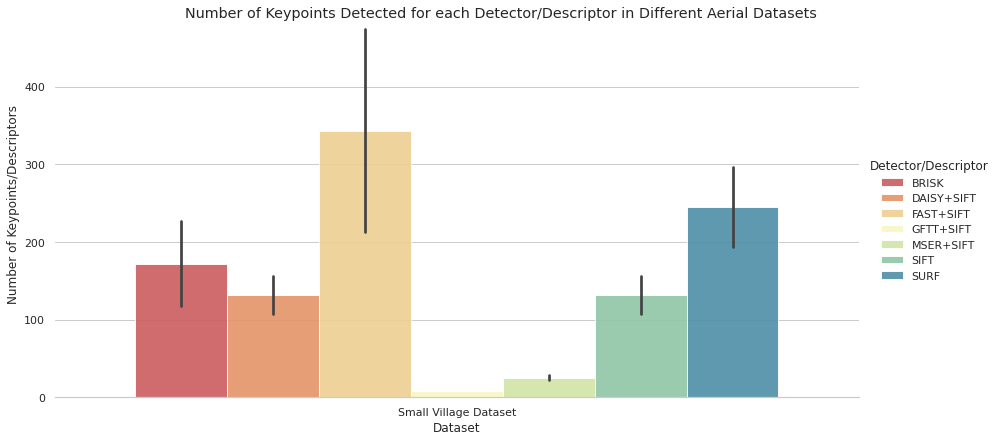

In [132]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_numkey_7, kind="bar",
    x="Dataset", y="Number of Keypoints", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=6, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Keypoints/Descriptors")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets")

In [133]:
g.savefig(f'drive/MyDrive/Num_Kypoints_7_{Dataset}.png')

In [134]:
df_numkey_7.to_csv(f'drive/MyDrive/Num_Kypoints_7_{Dataset}.csv')

Total Number of Matches Detected for each Detector+Descriptor

In [135]:
#df_match_15['Number of Total Matches'] =  num_matches_agast + num_matches_akaze + num_matches_brisk + num_matches_daisy + num_matches_fast + num_matches_freak + num_matches_gftt + num_matches_kaze + num_matches_mser + num_matches_orb + num_matches_rootsift + num_matches_sift + num_matches_briefstar + num_matches_superpoint+ num_matches_surf+ num_matches_surfsift
d = {'Dataset': [f'{Dataset}']*(num_detectors*(len_files-1)), 'Number of Total Matches': num_matches_brisk + num_matches_daisy + num_matches_fast + num_matches_gftt + num_matches_mser + num_matches_sift + num_matches_surf, 'Detector/Descriptor': ['BRISK']*(len_files-1) + ['DAISY+SIFT']*(len_files-1) + ['FAST+SIFT']*(len_files-1) + ['GFTT+SIFT']*(len_files-1) + ['MSER+SIFT']*(len_files-1) + ['SIFT']*(len_files-1) +  ['SURF']*(len_files-1) }
df_match_7 = pd.DataFrame(data=d)
df_match_7['Number of Total Matches'] = df_match_7['Number of Total Matches']/(len_files-1)

Text(0.5, 0.98, 'Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets')

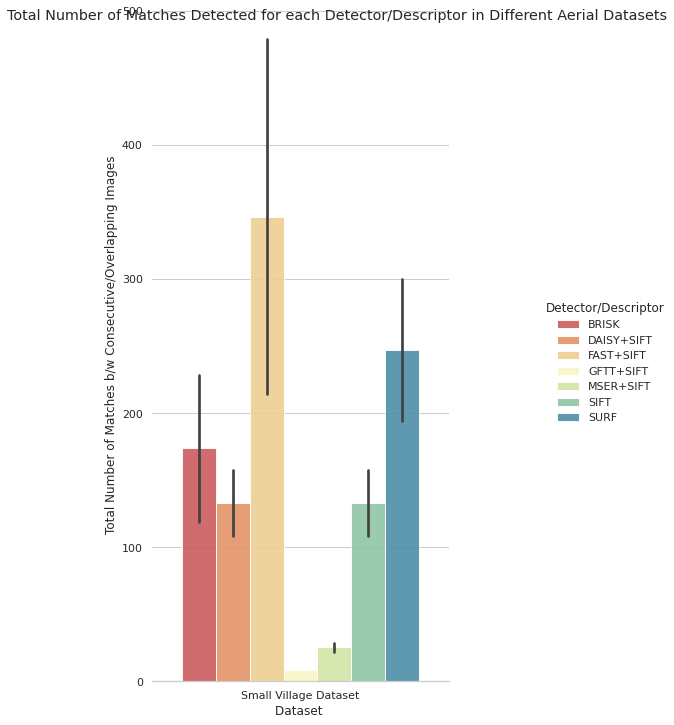

In [136]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_7, kind="bar",
    x="Dataset", y="Number of Total Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset ", "Total Number of Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets")

In [137]:
g.savefig(f'drive/MyDrive/Num_Matches_7_{Dataset}.png')

Total Number of Good/Robust Matches (NN+Lowe+RANSAC) Detected for each Detector+Descriptor

In [138]:
df_match_7['Number of Good Matches'] = num_good_matches_brisk + num_good_matches_daisy + num_good_matches_fast + num_good_matches_gftt + num_good_matches_mser + num_good_matches_sift + num_good_matches_surf
df_match_7['Number of Good Matches'] = df_match_7['Number of Good Matches']/(len_files-1)

Text(0.5, 0.98, 'Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets')

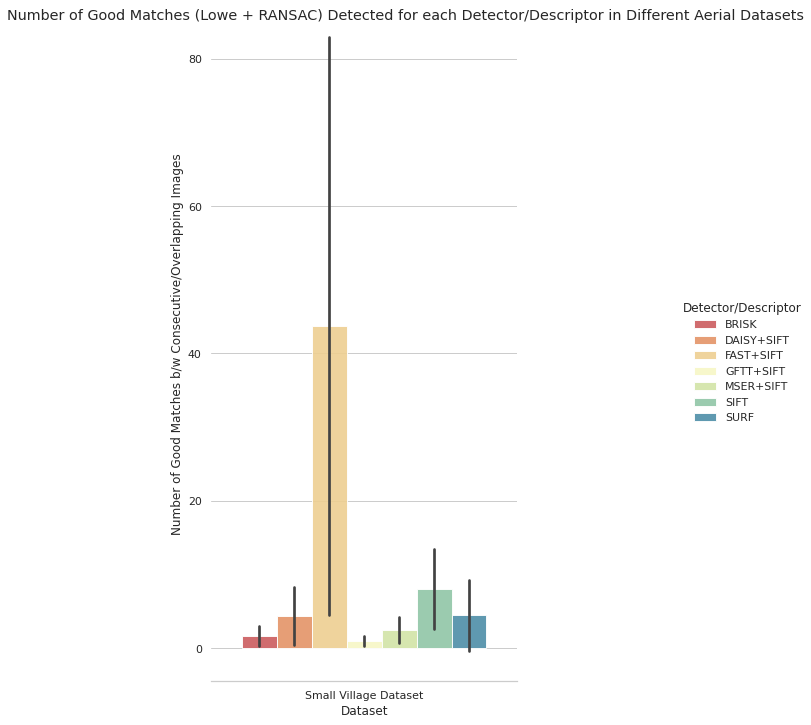

In [139]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_7, kind="bar",
    x="Dataset", y="Number of Good Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Good Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets")

In [140]:
g.savefig(f'drive/MyDrive/Num_Good_Matches_7_{Dataset}.png')

Recall Rate for each Detector+Descriptor

In [141]:
df_match_7['Recall Rate of Matches'] = df_match_7['Number of Good Matches']/df_match_7['Number of Total Matches']

Text(0.5, 0.98, 'Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

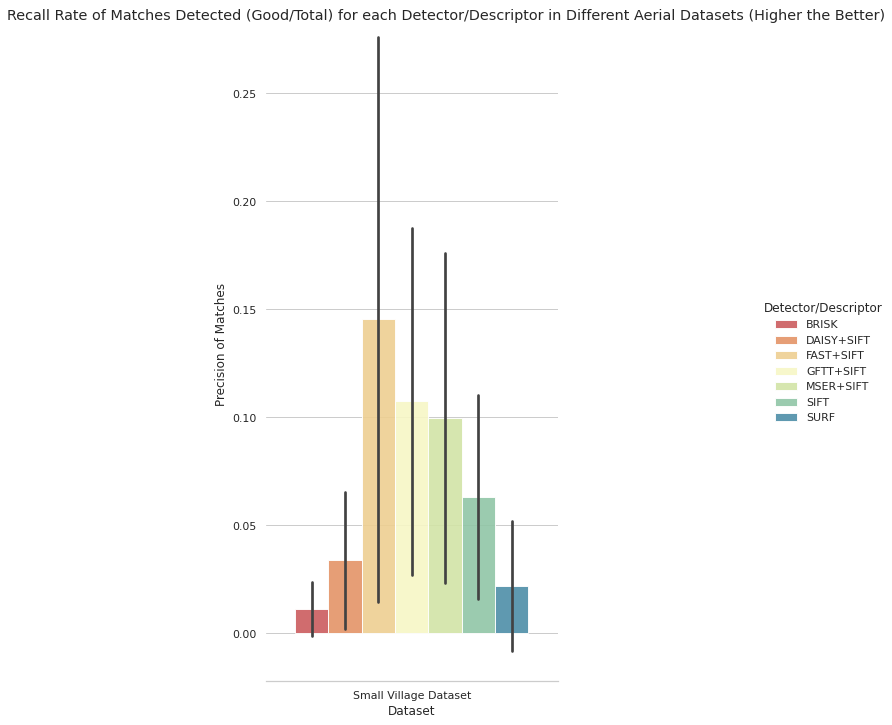

In [142]:
import seaborn as sns
sns.set_theme(style='whitegrid')


g = sns.catplot(
    data=df_match_7, kind="bar",
    x="Dataset", y="Recall Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Precision of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [143]:
g.savefig(f'drive/MyDrive/Recall_Rate_Matches_7_{Dataset}.png')

1-Precision Rate for each Detector+Descriptor

In [144]:
df_match_7['1 - Precision Rate of Matches'] = (df_match_7['Number of Total Matches'] - df_match_7['Number of Good Matches'])/df_match_7['Number of Total Matches']

Text(0.5, 0.98, '1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

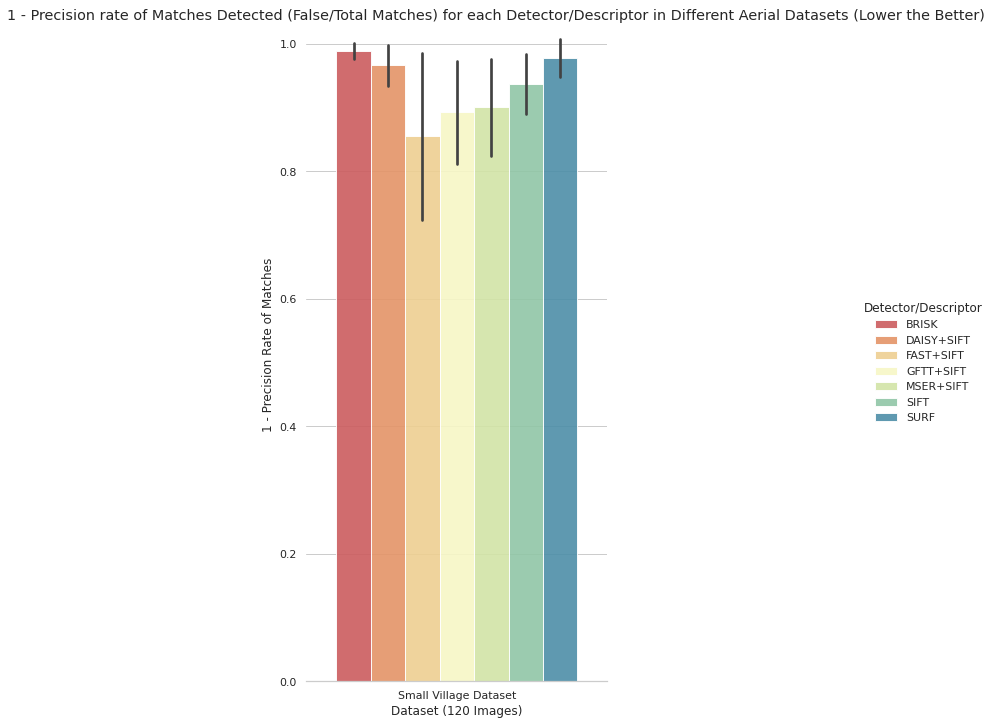

In [145]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_7, kind="bar",
    x="Dataset", y="1 - Precision Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset (120 Images)", "1 - Precision Rate of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [146]:
g.savefig(f'drive/MyDrive/One_minus_Precision_Rate_Matches_7_{Dataset}.png')

F-Score for each Detector+Descriptor

In [147]:
df_match_7['F-Score'] = (2* (1 - df_match_7['1 - Precision Rate of Matches']) * df_match_7['Recall Rate of Matches'])/((1 - df_match_7['1 - Precision Rate of Matches']) + df_match_7['Recall Rate of Matches'])

Text(0.5, 0.98, 'F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

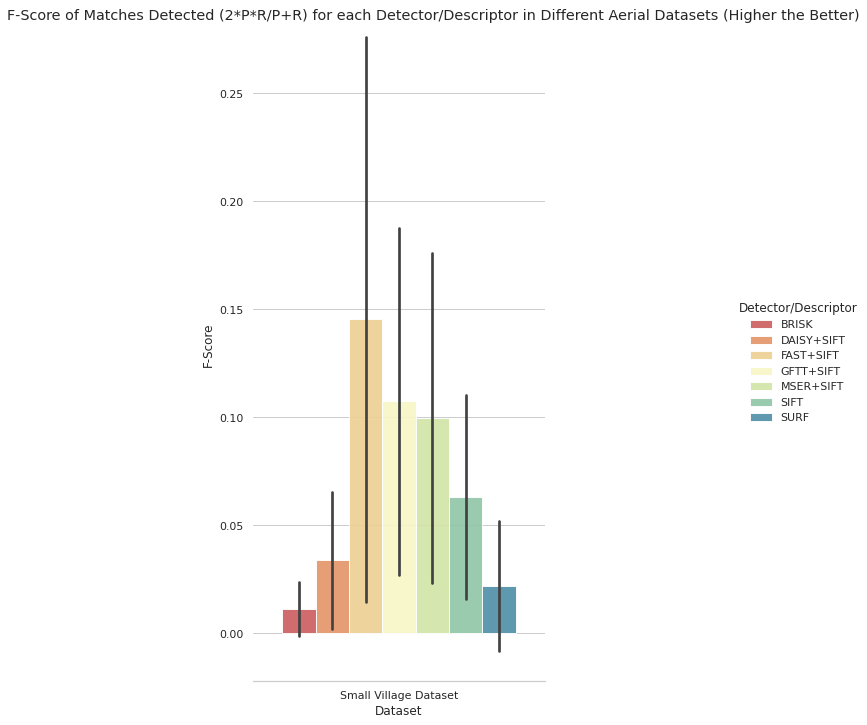

In [148]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_7, kind="bar",
    x="Dataset", y="F-Score", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "F-Score")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [149]:
g.savefig(f'drive/MyDrive/F_Score_Rate_Matches_7_{Dataset}.png')

In [150]:
df_match_7.to_csv(f'drive/MyDrive/All_metrics_7_{Dataset}.csv')

Time for each Detector+Descriptor

In [152]:
d = {'Dataset': [f'{Dataset}']*(num_detectors), 'Time':  [time_all[3]] + [time_all[0]] + [time_all[5]] + [time_all[2]] + [time_all[6]] + [time_all[1]]+ [time_all[4]] , 'Detector/Descriptor': ['BRISK']*(1) + ['DAISY+SIFT']*(1) + ['FAST+SIFT']*(1)  + ['GFTT+SIFT']*(1) + ['MSER+SIFT']*(1) +['SIFT']*(1) + ['SURF']*(1)} 
df_time_7 = pd.DataFrame(data=d)

Text(0.5, 0.98, 'Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

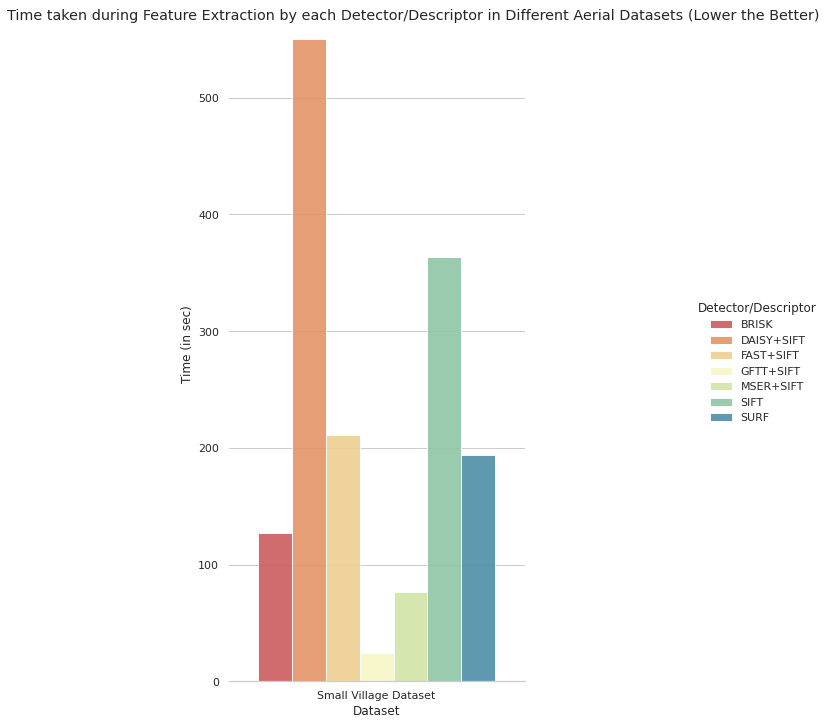

In [153]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_time_7, kind="bar",
    x="Dataset", y="Time", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Time (in sec)")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [154]:
g.savefig(f'drive/MyDrive/Time_7_{Dataset}.png')

In [155]:
df_time_7.to_csv(f'drive/MyDrive/Time_7_{Dataset}.csv')